### Inventory Preprocessing

In [2]:
import pandas as pd

# File paths
file_2023 = "Inventory Transaction Data 2023 v0.1.xlsx"
file_2024 = "Inventory Transaction Data 2024 v0.1.xlsx"

# Load Excel files
xls_2023 = pd.ExcelFile(file_2023)
xls_2024 = pd.ExcelFile(file_2024)

# Skip first 2 rows and drop empty columns
df_2023 = xls_2023.parse("Inventory Trans", skiprows=2)
df_2023 = df_2023.dropna(axis=1, how='all')

# Rename columns
df_2023.columns = [
    "Transaction Date", "Transaction Hour", "COMBO Indicator",
    "Combo Item", "Item Class", "VISTA Item", "No of Items", "Sell Price EA"
]

# Skip first 2 rows and drop empty columns
df_2024 = xls_2024.parse("Inventory Trans", skiprows=2)
df_2024 = df_2024.dropna(axis=1, how='all')
# Rename columns
df_2024.columns = [
    "Transaction Date", "Transaction Hour", "COMBO Indicator",
    "Combo Item", "Item Class", "VISTA Item", "No of Items", "Sell Price EA"
]

# Concatenate the two datasets (2023 first, then 2024)
merged_inventory = pd.concat([df_2023, df_2024], ignore_index=True)

# Remove rows with blank or "Overall Result" in Transaction Date
merged_inventory = merged_inventory[
    merged_inventory["Transaction Date"].notna() &
    (merged_inventory["Transaction Date"] != "Overall Result")
]



######Daily revenue csv######
# Filter rows where Transaction Hour contains "Result"
result_rows = merged_inventory[
    merged_inventory["Transaction Hour"].astype(str).str.contains("Result", case=False, na=False)
]

# Create the daily_revenue DataFrame
daily_revenue = result_rows[["Transaction Date", "Sell Price EA"]].copy()
daily_revenue.columns = ["Date", "Total Revenue"]

# Reset index for cleanliness
daily_revenue.reset_index(drop=True, inplace=True)
daily_revenue.to_csv("daily_revenue.csv", index=False)
print("Daily revenue data saved to 'daily_revenue.csv'. ✅")

###########################

# Drop rows where 'Transaction Hour' contains "Result" (string check)
merged_inventory = merged_inventory[
    ~merged_inventory["Transaction Hour"].astype(str).str.contains("Result", case=False, na=False)
]
# Convert 'Transaction Date' to datetime
merged_inventory["Transaction Date"] = pd.to_datetime(
    merged_inventory["Transaction Date"], errors="coerce", dayfirst=True
)

# Convert 'Transaction Hour' to numeric WITHOUT filling blanks
merged_inventory["Transaction Hour"] = pd.to_numeric(
    merged_inventory["Transaction Hour"], errors="coerce"
)

# Keep only rows where COMBO Indicator is not 'Y'
merged_inventory = merged_inventory[merged_inventory["COMBO Indicator"] != "Y"].copy()

###########################DAILY SESSION HOUR REVENUE#######################
# Group by Transaction Date and Transaction Hour, and sum the revenue
daily_session_hour_revenues = merged_inventory.groupby(
    ["Transaction Date", "Transaction Hour"]
)["Sell Price EA"].sum().reset_index()

# Rename columns
daily_session_hour_revenues.columns = ["Date", "Session Hour", "Total Revenue"]
# Save to CSV
daily_session_hour_revenues.to_csv("Daily_Session_Hour_Revenues.csv", index=False)
print("✅ Exported to Daily_Session_Hour_Revenues.csv")

########################Clean merged inventory##################
merged_inventory = merged_inventory.drop(columns=["COMBO Indicator"])

# Confirm it's removed
merged_inventory.to_excel("Cleaned_Merged_Inventory.xlsx", index=False)

print("Exported to Cleaned_Merged_Inventory.xlsx ✅")

Daily revenue data saved to 'daily_revenue.csv'. ✅
✅ Exported to Daily_Session_Hour_Revenues.csv
Exported to Cleaned_Merged_Inventory.xlsx ✅


### Sessions Preprocessing

In [4]:
import pandas as pd

# Load the movie sessions data
sessions_path = "Movie_sessions.xlsx"
sessions_df = pd.read_excel(sessions_path, sheet_name="Sheet1")


sessions_df = sessions_df[sessions_df["Session Audio Language"] != "Overall Result"]
sessions_df = sessions_df[sessions_df["Duration"] != "960 MIN"]

# Step 1: Convert 'Duration' to numeric (strip ' MIN')
sessions_df["Duration"] = sessions_df["Duration"].str.replace(" MIN", "").astype(int)

# Create a single 'Duration Category' column based on defined ranges
sessions_df["Duration Category"] = pd.cut(
    sessions_df["Duration"],
    bins=[0, 90, 120, float('inf')],
    labels=["Short", "Medium", "Long"],
    right=False
)


# Create a function to generate all session hours based on the starting hour and duration
def get_session_hours(row):
    start_hour = int(row['Session Hour'])  # Convert start hour to integer
    duration = row['Duration']  # Duration is already in minutes
    
    # Calculate the end hour by adding duration (converted to hours) to start hour
    end_hour = start_hour + (duration // 60)  # Calculate end hour (ignoring minutes for simplicity)
    
    # Generate the list of hours the movie will run (from start hour to end hour)
    session_hours = list(range(start_hour, end_hour + 1))
    return session_hours

#Apply the function to get session hours
sessions_df['Session Hours'] = sessions_df.apply(get_session_hours, axis=1)

###################################################cleaned movie session with session hours
# Export the dataframe with the 'Session Hours' column to a CSV file
sessions_df.to_csv("Cleaned_Movie_Sessions_with_Session_Hours.csv", index=False)

print("✅ Exported the dataset to 'Cleaned_Movie_Sessions_with_Session_Hours.csv'")
##################################################

# Drop the 'Duration' column since we have the 'Session Hours' column now
sessions_df = sessions_df.drop(columns=["Duration"])


# One-hot encode categorical columns: 'Session Audio Language', 'Genre', 'Censor Rating', 'Duration Category'
dummies = pd.get_dummies(
    sessions_df[["Session Audio Language", "Genre", "Censor Rating", "Duration Category"]],
    prefix=["Lang", "Genre", "Rating", "Duration"]
)

# Convert the boolean columns to 0/1
dummies = dummies.astype(int)

# Add the one-hot encoded columns to the original dataframe
sessions_df = pd.concat([sessions_df, dummies], axis=1)

# Drop the original categorical columns after one-hot encoding
sessions_df = sessions_df.drop(columns=["Session Audio Language", "Genre", "Censor Rating", "Duration Category"])
#####################################################
sessions_df.to_csv("Cleaned_Movie_Sessions_with_Session_Hours.csv", index=False)


# Step 1: Create a function to generate the exploded dataframe based on session hours
def explode_session_hours(df):
    exploded_rows = []
    
    for _, row in df.iterrows():
        session_hours = row['Session Hours']  # Get the list of session hours for this row
        total_admits = row['Total Admits']  # Get the total admits
        one_hot_columns = row.drop(['Session Date', 'Session Hour', 'Total Admits', 'Session Hours'])  # Get the one-hot encoded columns
        
        # For each session hour in the list, create a new row
        for i, hour in enumerate(session_hours):
            # If it's the first hour, keep the total admits, otherwise set it to 0
            if i == 0:
                new_row = row.copy()  # Keep all original data for the first session hour
                new_row['Session Hour'] = hour
                exploded_rows.append(new_row)
            else:
                # For subsequent hours, set total admits and one-hot encoded columns to 0
                new_row = row.copy()
                new_row['Session Hour'] = hour
                new_row['Total Admits'] = 0
                new_row[one_hot_columns.index] = 0  # Set all one-hot columns to 0
                exploded_rows.append(new_row)
    
    # Create a new dataframe from the exploded rows
    exploded_df = pd.DataFrame(exploded_rows).reset_index(drop=True)
    return exploded_df

# Step 2: Apply the explode function to create the final dataframe
sessions_exploded_df = explode_session_hours(sessions_df)



#######################################
# Step 4: Export the exploded dataframe to CSV for later use
sessions_exploded_df.to_csv("Exploded_Sessions_with_Session_Hours.csv", index=False)

print("✅ Exported the exploded dataset to 'Exploded_Sessions_with_Session_Hours.csv'")
########################################


# Step 1: Drop the 'Session Hours' and 'Film' columns after exploding the data
sessions_exploded_df = sessions_exploded_df.drop(columns=["Session Hours", "Film"])

# Aggregate by 'Session Date' and 'Session Hour', summing the relevant columns (and all other columns)
aggregated_sessions_df = sessions_exploded_df.groupby(['Session Date', 'Session Hour']).agg(
    {col: 'sum' for col in sessions_exploded_df.columns if col not in ['Session Date', 'Session Hour']}).reset_index()


#####################################
# Step 4: Export the aggregated data to a CSV file
aggregated_sessions_df.to_csv("Aggregated_Sessions1.csv", index=False)

print("✅ Exported the aggregated dataset to 'Aggregated_Sessions1.csv'")
######################################


✅ Exported the dataset to 'Cleaned_Movie_Sessions_with_Session_Hours.csv'
✅ Exported the exploded dataset to 'Exploded_Sessions_with_Session_Hours.csv'
✅ Exported the aggregated dataset to 'Aggregated_Sessions1.csv'


### Merging code

In [6]:
# Load the daily session hour revenues data
revenue_path = "Daily_Session_Hour_Revenues.csv"
daily_session_hour_revenues = pd.read_csv(revenue_path)
# Load the Aggregated session data
aggregated_sessions_df_path = "Aggregated_Sessions1.csv"
aggregated_sessions_df= pd.read_csv(aggregated_sessions_df_path)


# Step 1: Strip leading and trailing spaces from 'Date' column
daily_session_hour_revenues['Date'] = daily_session_hour_revenues['Date'].str.strip()

# Step 2: Convert 'Date' to datetime format (YYYY-MM-DD)
daily_session_hour_revenues['Date'] = pd.to_datetime(
    daily_session_hour_revenues['Date'], 
    errors='coerce',  # Invalid dates will be set to NaT
    dayfirst=False    # Default format (YYYY-MM-DD)
)

# Convert 'Session Date' in aggregated_sessions_df to datetime (standardize format)
aggregated_sessions_df['Session Date'] = pd.to_datetime(
    aggregated_sessions_df['Session Date'], 
    format='%d.%m.%Y',  # Specify the format as dd.mm.yyyy 
    errors='coerce'
)

# Perform the left join to retain all rows from aggregated_sessions_df and match with daily_session_hour_revenues
merged_data = pd.merge(
    aggregated_sessions_df,
    daily_session_hour_revenues,
    left_on=['Session Date', 'Session Hour'],
    right_on=['Date', 'Session Hour'],
    how='left'  # Perform a left join to keep all rows from aggregated_sessions_df
)

# Replace NaN in 'Total Revenue' with 0 for unmatched rows
merged_data['Total Revenue'].fillna(0, inplace=True)

# Drop the redundant 'Date' column after the merge, since we already have 'Session Date'
merged_data = merged_data.drop(columns=['Date'])

#########################################
# Export the merged data to a CSV file for further use
merged_data.to_csv("Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv", index=False)

print("✅ Exported the merged dataset to 'Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv'")


✅ Exported the merged dataset to 'Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv'


C:\Users\Pranjal\AppData\Local\Temp\ipykernel_28568\4066960456.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['Total Revenue'].fillna(0, inplace=True)


### Sales forecasting Preprocessing

In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Merged_Aggregated_Sessions_with_Revenue_Left_Join.csv")
# 🕒 Convert 'Session Date' to datetime
df['Session Date'] = pd.to_datetime(df['Session Date'], errors='coerce')
#######################################################################

# 🚨 Check for any conversion issues (NaT values)
conversion_issues = df[df['Session Date'].isnull()]
if not conversion_issues.empty:
    print("\n⚠️ Conversion issues found:")
    print(conversion_issues)
else:
    print("\n✅ All dates converted successfully.")

# 📆 Extract day of week and month from 'Session Date'
df['DayOfWeek'] = df['Session Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Month'] = df['Session Date'].dt.month

##################################################################
# 💾 Export the updated DataFrame to CSV
df.to_csv("forecasting_data.csv", index=False)
print("✅ Data exported to 'forecasting_data.csv'")
#################################################################

# 📋 Create a copy of the dataset without 'Session Date' for modeling
df_model = df.drop(columns=['Session Date'])



✅ All dates converted successfully.
✅ Data exported to 'forecasting_data.csv'


### Sales Forecasting modelling

✔️  Saved 56 feature names to feature_list.pkl
X_train shape: (8140, 56)
X_test shape: (2036, 56)
y_train shape: (8140,)
y_test shape: (2036,)
🌲 Random Forest Performance:
MAE:  87.44
RMSE: 141.39
R²:   0.73
🚀 XGBoost Performance:
MAE:  85.66
RMSE: 138.82
R²:   0.74

📊 Random Forest Performance:
MAE:       87.44
RMSE:      141.39
R² Score:  0.73
Accuracy within ±10%: 21.17%

📊 XGBoost Performance:
MAE:       85.66
RMSE:      138.82
R² Score:  0.74
Accuracy within ±10%: 10.81%


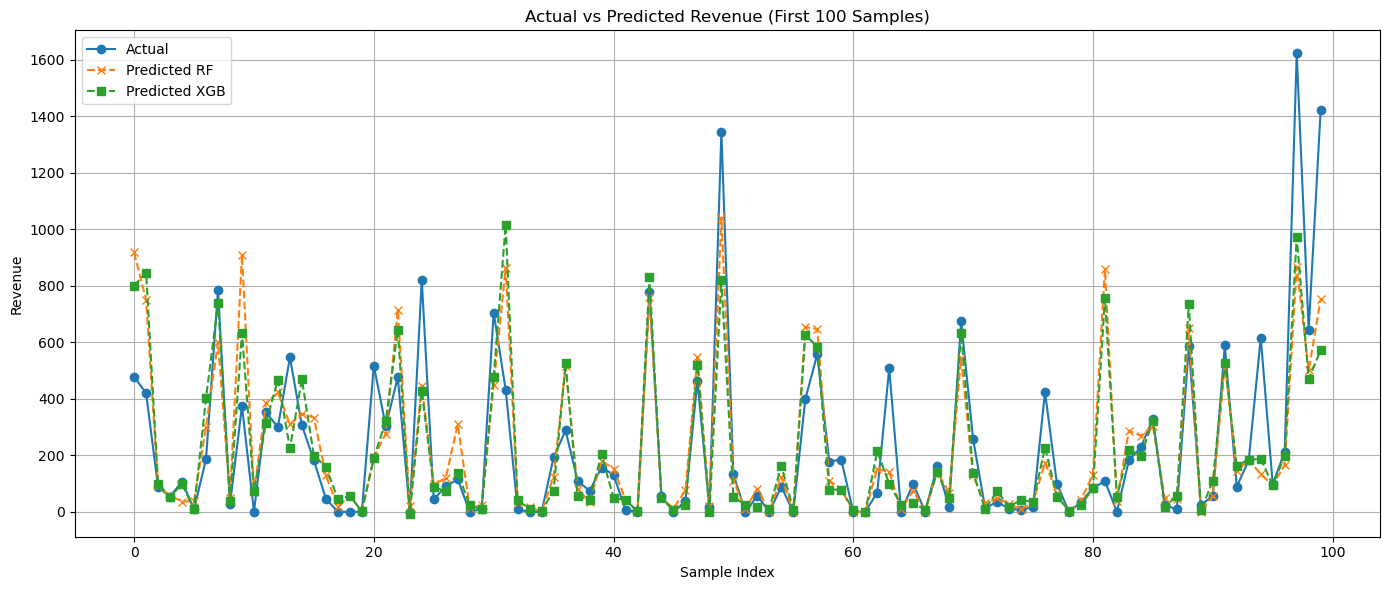

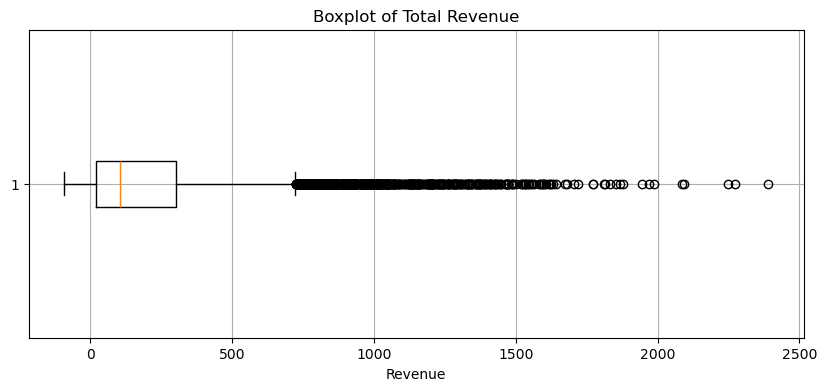

📌 Number of outliers: 629
Revenue below -401.75 or above 724.25 considered outliers.


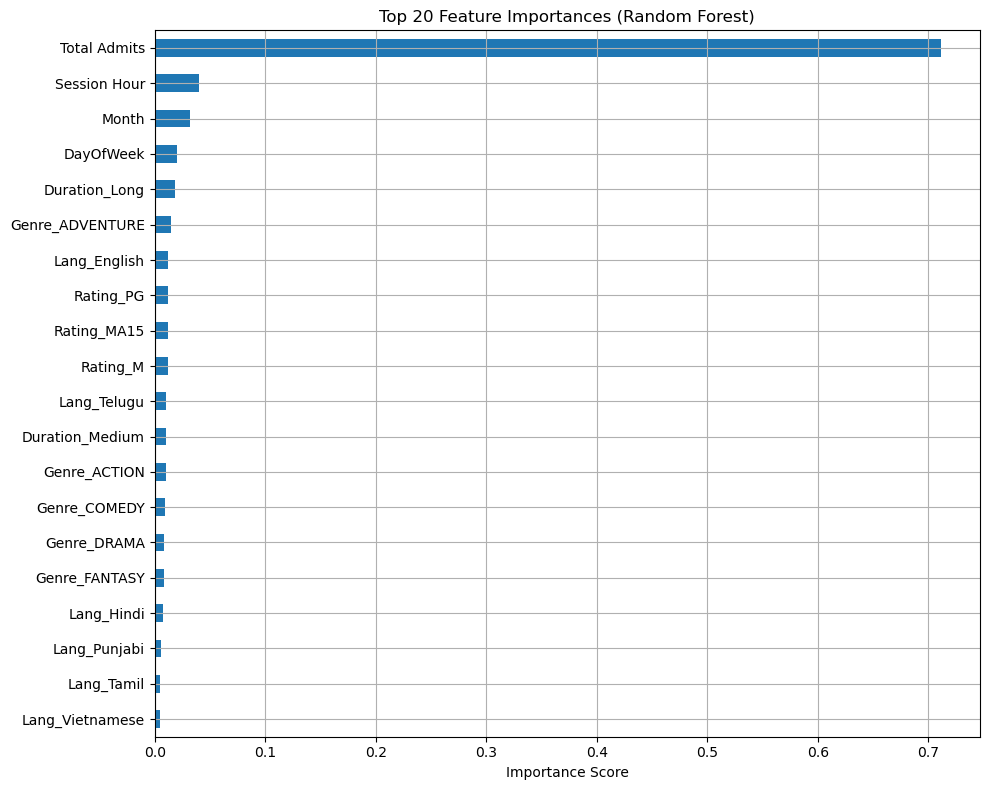

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 8140, number of used features: 48
[LightGBM] [Info] Start training from score 215.114374

📊 LightGBM Performance:
MAE:  83.62
RMSE: 133.78
R²:   0.76
Accuracy within ±10%: 11.54%

📊 CatBoost Performance:
MAE:  83.05
RMSE: 131.89
R²:   0.77
Accuracy within ±10%: 11.74%


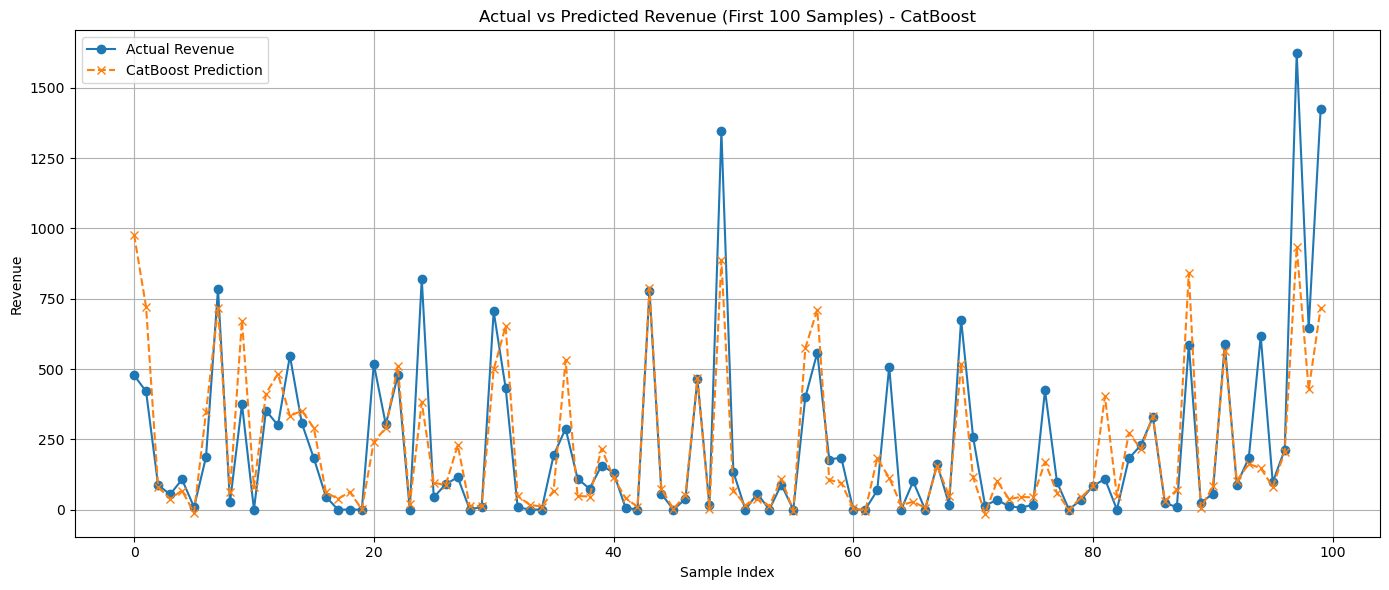

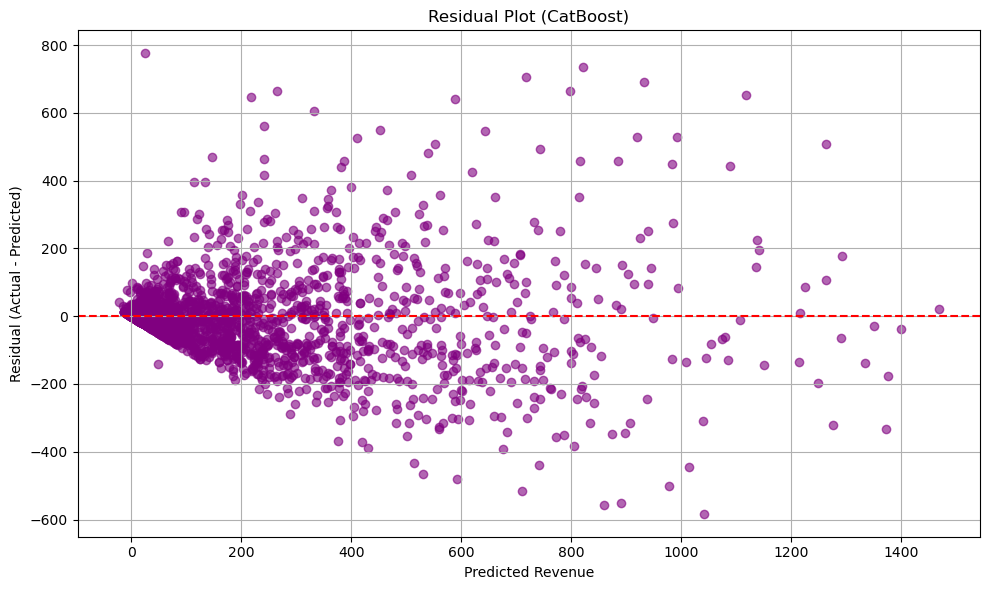

Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters Found:
{'learning_rate': 0.07, 'l2_leaf_reg': 7, 'iterations': 700, 'depth': 8, 'bagging_temperature': 0.5}

📊 Tuned CatBoost Performance:
MAE:  82.04
RMSE: 130.43
R²:   0.77
Accuracy within ±10%: 10.81%


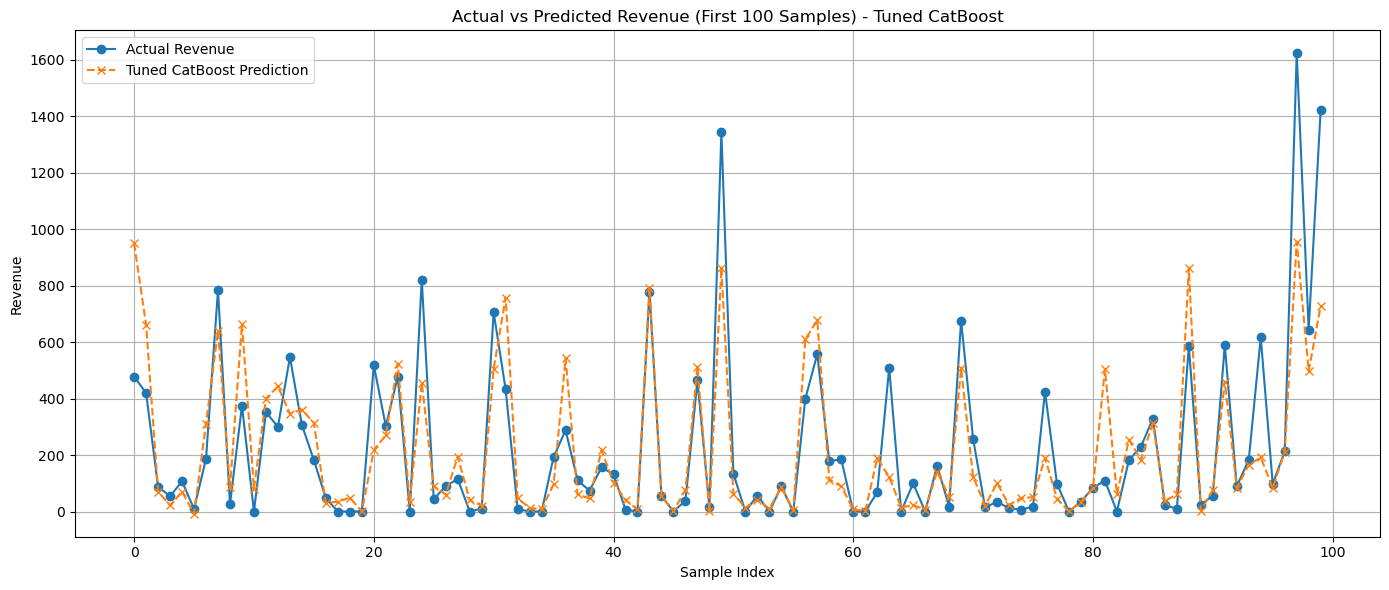

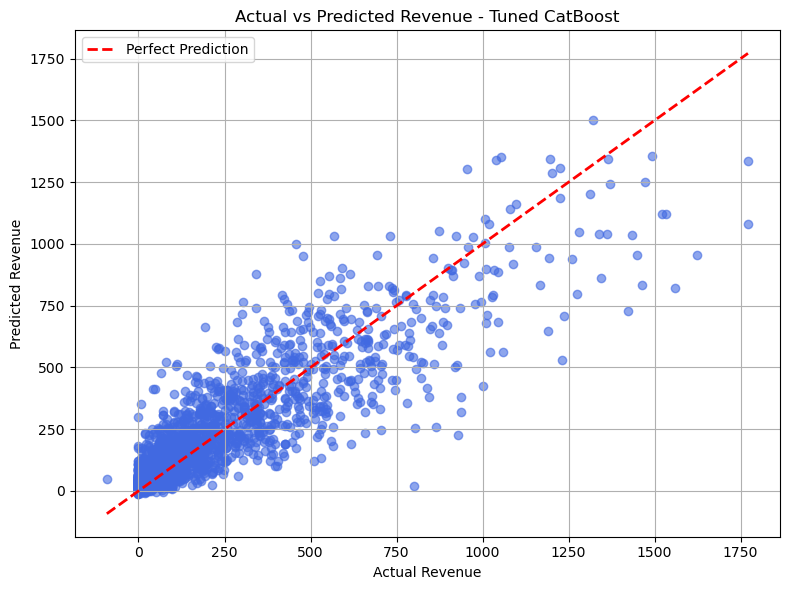

In [10]:
from sklearn.model_selection import train_test_split
#######################Scriptt for validation enhancing as having columns mismatch############
import pandas as pd
import joblib
# df_model=df
# # (A) Date → Month & Day-of-Week features
# # ──────────────────────────────────────────────────
# df_model['Session Date'] = pd.to_datetime(df_model['Session Date'])
# df_model['session_month']    = df_model['Session Date'].dt.month
# df_model['session_dayofweek'] = df_model['Session Date'].dt.dayofweek
# df_model.drop(columns=['Session Date'], inplace=True)




# 1. Extract feature list
feature_list = [c for c in df_model.columns if c != "Total Revenue"]

# 2. Persist it
joblib.dump(feature_list, "feature_list.pkl")
print(f"✔️  Saved {len(feature_list)} feature names to feature_list.pkl")

######################################################################################################
# 🎯 Separate features and target
X = df_model.drop(columns=['Total Revenue'])
y = df_model['Total Revenue']

# 🧪 Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Confirm the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 🔧 Initialize and train model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 📊 Predict on test set
y_pred_rf = rf_model.predict(X_test)

# 🧮 Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Random Forest Performance:")
print(f"MAE:  {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²:   {r2_rf:.2f}")



from xgboost import XGBRegressor

# 🔧 Initialize and train model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# 📊 Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# 🧮 Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("🚀 XGBoost Performance:")
print(f"MAE:  {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²:   {r2_xgb:.2f}")


# 🔁 For both models
def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Custom accuracy: predictions within ±10% of actual value
    tolerance = 0.10
    accuracy_within_10 = np.mean(
        np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))
    ) * 100

    print(f"\n📊 {model_name} Performance:")
    print(f"MAE:       {mae:.2f}")
    print(f"RMSE:      {rmse:.2f}")
    print(f"R² Score:  {r2:.2f}")
    print(f"Accuracy within ±10%: {accuracy_within_10:.2f}%")

# 👉 Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# 👉 Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")



# 📋 Create a comparison DataFrame
comparison_df = X_test.copy()
comparison_df['Actual Revenue'] = y_test
comparison_df['Predicted RF'] = y_pred_rf
comparison_df['Predicted XGB'] = y_pred_xgb

# 🔍 Show first few rows
comparison_df[['Actual Revenue', 'Predicted RF', 'Predicted XGB']].head()





import matplotlib.pyplot as plt

# 🔢 Limit to first 100 predictions for clarity
n = 100
plt.figure(figsize=(14, 6))
plt.plot(y_test.iloc[:n].values, label='Actual', marker='o')
plt.plot(y_pred_rf[:n], label='Predicted RF', linestyle='--', marker='x')
plt.plot(y_pred_xgb[:n], label='Predicted XGB', linestyle='--', marker='s')
plt.title("Actual vs Predicted Revenue (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.boxplot(df_model['Total Revenue'], vert=False)
plt.title("Boxplot of Total Revenue")
plt.xlabel("Revenue")
plt.grid(True)
plt.show()

# Calculate IQR
Q1 = df_model['Total Revenue'].quantile(0.25)
Q3 = df_model['Total Revenue'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_model[(df_model['Total Revenue'] < lower_bound) | (df_model['Total Revenue'] > upper_bound)]

print(f"📌 Number of outliers: {len(outliers)}")
print(f"Revenue below {lower_bound:.2f} or above {upper_bound:.2f} considered outliers.")

import pandas as pd
import matplotlib.pyplot as plt

# ✅ Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# 🪄 Create a Series and sort it
fi_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 📈 Plot Top 20 Features
plt.figure(figsize=(10, 8))
fi_series.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train LightGBM model
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgbm = lgbm_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Accuracy within ±10%
    tolerance = 0.10
    accuracy_10 = np.mean(np.abs(y_true - y_pred) <= (tolerance * np.abs(y_true))) * 100

    print(f"\n📊 {model_name} Performance:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")
    print(f"Accuracy within ±10%: {accuracy_10:.2f}%")

# Evaluate
evaluate_model(y_test, y_pred_lgbm, "LightGBM")


from catboost import CatBoostRegressor

# Train CatBoost model (silent mode)
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_cat = catboost_model.predict(X_test)
evaluate_model(y_test, y_pred_cat, "CatBoost")


# Create a DataFrame for comparison
import pandas as pd

comparison_cat = pd.DataFrame({
    'Actual Revenue': y_test.values,
    'Predicted Revenue (CatBoost)': y_pred_cat
})

# Show top 10
comparison_cat.head(10)


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:100], label='Actual Revenue', marker='o')
plt.plot(y_pred_cat[:100], label='CatBoost Prediction', linestyle='--', marker='x')
plt.title("Actual vs Predicted Revenue (First 100 Samples) - CatBoost")
plt.xlabel("Sample Index")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Residuals = actual - predicted
comparison_cat['Residual'] = comparison_cat['Actual Revenue'] - comparison_cat['Predicted Revenue (CatBoost)']

# Show rows with largest absolute errors
comparison_cat['Absolute Error'] = comparison_cat['Residual'].abs()
comparison_cat_sorted = comparison_cat.sort_values(by='Absolute Error', ascending=False)

# Show top 10 worst predictions
comparison_cat_sorted.head(10)


plt.figure(figsize=(10, 6))
plt.scatter(y_pred_cat, comparison_cat['Residual'], alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (CatBoost)")
plt.xlabel("Predicted Revenue")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()





from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

# Base CatBoost model
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# Parameter grid for tuning
param_dist = {
    'depth': [6, 8, 10],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1, 2]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=20,  # number of parameter combinations to try
    scoring='neg_root_mean_squared_error',  # because we're minimizing RMSE
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Print best parameters
print("✅ Best Parameters Found:")
print(random_search.best_params_)

# Retrieve the best model
best_cat_model = random_search.best_estimator_


# Predict using tuned CatBoost
y_pred_tuned_cat = best_cat_model.predict(X_test)

# Evaluate performance
evaluate_model(y_test, y_pred_tuned_cat, "Tuned CatBoost")



import pandas as pd

# Create comparison DataFrame
comparison_tuned_cat = pd.DataFrame({
    'Actual Revenue': y_test.values,
    'Predicted Revenue (Tuned CatBoost)': y_pred_tuned_cat
})

# Show top 10
comparison_tuned_cat.head(10)



import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:100], label='Actual Revenue', marker='o')
plt.plot(y_pred_tuned_cat[:100], label='Tuned CatBoost Prediction', linestyle='--', marker='x')
plt.title("Actual vs Predicted Revenue (First 100 Samples) - Tuned CatBoost")
plt.xlabel("Sample Index")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tuned_cat, alpha=0.6, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title("Actual vs Predicted Revenue - Tuned CatBoost")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [11]:
################Dumping the best model which is fined catboost################
import joblib

# best_cat_model is the tuned CatBoostRegressor from RandomizedSearchCV
joblib.dump(best_cat_model, "best_catboost_model.pkl")
print("✅ Pickled Tuned CatBoost to best_catboost_model.pkl")


✅ Pickled Tuned CatBoost to best_catboost_model.pkl


In [12]:

# # right after you train xgb_model in your training cell
# joblib.dump(xgb_model, "best_xgb_model.pkl")
# print("✅ Pickled XGBoost as best_xgb_model.pkl")

### Inventory Main preprocessing

In [14]:
import pandas as pd

# Load the datasets
forecasting_df = pd.read_csv("forecasting_data.csv")
inventory_df = pd.read_excel("Cleaned_Merged_Inventory.xlsx", sheet_name='Sheet1')
# Drop columns not needed for forecasting
inventory_df = inventory_df.drop(columns=["VISTA Item", "Combo Item"])

# Drop the 'Year' column
# inventory_df = inventory_df.drop(columns=["Year"])

# Item classes we want to drop explicitly
drop_classes = [
    'VREWARDS', 'VREWARDS POINTS TRAN', 'VOUCHERS & SCREEN SA', 'PROMOTIONAL (GC)',
    'MODIFIERS', 'SUPPLEMENTARY ITEMS', 'GIFT CARDS', 'COMBO VOUCHERS',
    'DELIVERY', 'FUNCTION AND GROUP S'
]
# Drop those classes from the inventory
inventory_df = inventory_df[~inventory_df["Item Class"].isin(drop_classes)]



# Step 1: Aggregate item counts per class per session
item_counts = inventory_df.groupby(["Transaction Date", "Transaction Hour", "Item Class"])["No of Items"].sum().reset_index()

# Step 2: Pivot so each item class is a column
item_class_pivot = item_counts.pivot_table(
    index=["Transaction Date", "Transaction Hour"],
    columns="Item Class",
    values="No of Items",
    fill_value=0
).reset_index()

# Step 3: Calculate total session revenue (using Sell Price EA as already total)
revenue_per_session = inventory_df.groupby(["Transaction Date", "Transaction Hour"])["Sell Price EA"].sum().reset_index()

# Step 4: Merge item class counts with total revenue
final_inventory_summary = pd.merge(
    item_class_pivot,
    revenue_per_session,
    on=["Transaction Date", "Transaction Hour"],
    how="left"
)

# Step 5: Rename revenue column for clarity
final_inventory_summary = final_inventory_summary.rename(columns={"Sell Price EA": "Total Session Revenue"})

###############################################################
final_inventory_summary.to_csv("final_inventory_summary.csv", index=False)
################################################################


# Convert date columns to datetime if not already
forecasting_df["Session Date"] = pd.to_datetime(forecasting_df["Session Date"])
final_inventory_summary["Transaction Date"] = pd.to_datetime(final_inventory_summary["Transaction Date"])

# Now perform the merge
merged_df = forecasting_df.merge(
    final_inventory_summary,
    how="inner",
    left_on=["Session Date", "Session Hour"],
    right_on=["Transaction Date", "Transaction Hour"]
)

# Drop duplicate columns from right side
merged_df = merged_df.drop(columns=["Transaction Date", "Transaction Hour"])

########################################################################
merged_df.to_csv("basketanalysis.csv", index=False)
########################################################################

In [15]:
merged_df.columns

Index(['Session Date', 'Session Hour', 'Total Admits', 'Lang_Assamese',
       'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
       'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
       'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
       'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
       'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
       'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese', 'Genre_ACTION',
       'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY', 'Genre_COMEDY',
       'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA', 'Genre_FAMILY',
       'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR', 'Genre_MUSIC',
       'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE', 'Genre_SCI-FI',
       'Genre_THRILLER', 'Genre_TO BE ADVISED', 'Rating_CTC', 'Rating_E',
       'Rating_G', 'Rating_M', 'Rating_MA15', 'Rating_PG', 'Rating_R18+',
       'Duration_Short', 'Duration_Medium'

### Modellings

In [17]:
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Load data
basket_df = pd.read_csv("basketanalysis.csv")

# ────────────────
# Define features
# ────────────────
feature_cols = [
    'Session Hour', 'Total Admits',
    'Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
    'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
    'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
    'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
    'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
    'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese',
    'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY',
    'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA',
    'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR',
    'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE',
    'Genre_SCI-FI', 'Genre_THRILLER', 'Genre_TO BE ADVISED',
    'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_MA15',
    'Rating_PG', 'Rating_R18+',
    'Duration_Short', 'Duration_Medium', 'Duration_Long',
    'DayOfWeek', 'Month'
]

# ────────────────
# Define targets
# ────────────────
target_cols = [
    'SNACK - CHIPS',
    'FOOD - VJUNIOR',
    'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE',
    'DRINKS',
    'DRINKS - SMALL',
    'DRINKS - MEDIUM',
    'ICE CREAMS - CHOC TO',
    'DRINKS - NO ICE',
    'DRINKS - LARGE',
    'POPCORN',
    'Total Session Revenue'
]

# Subset the DataFrame to only those columns, features first then targets
df_model = basket_df[feature_cols + target_cols].copy()

# Split into X and Y
X = df_model[feature_cols]
Y = df_model[target_cols]

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Train model
model = MultiOutputRegressor(Ridge())
model.fit(X_train, Y_train)

# Predict
Y_pred = model.predict(X_test)
Y_pred_df = pd.DataFrame(Y_pred, columns=target_cols)

# Calculate MAE and R² per item class
mae_per_item = {
    col: mean_absolute_error(Y_test[col], Y_pred_df[col])
    for col in target_cols
}
r2_per_item = {
    col: r2_score(Y_test[col], Y_pred_df[col])
    for col in target_cols
}

# Combine into DataFrame and sort by MAE
metrics_df = pd.DataFrame([
    {"Item Class": col, "MAE": mae_per_item[col], "R²": r2_per_item[col]}
    for col in target_cols
]).sort_values(by="MAE")

print(metrics_df)


               Item Class         MAE        R²
0           SNACK - CHIPS    0.753231  0.168962
2      ICE CREAMS - OTHER    1.271775  0.191191
3    DRINKS - EXTRA LARGE    1.371254  0.108744
1          FOOD - VJUNIOR    1.522749  0.188496
5          DRINKS - SMALL    2.934070  0.427886
6         DRINKS - MEDIUM    3.340983  0.567273
7    ICE CREAMS - CHOC TO    4.480372  0.465259
8         DRINKS - NO ICE    4.948984  0.358009
4                  DRINKS    5.679901  0.238309
9          DRINKS - LARGE    5.758444  0.649855
10                POPCORN    8.889094  0.746417
11  Total Session Revenue  115.024708  0.623881


### With Revenue details as target in catboost

In [19]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# 1) Load data
basket_df = pd.read_csv("basketanalysis.csv")

# 2) Define features explicitly
feature_cols = [
    'Session Hour', 'Total Admits',
    'Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
    'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
    'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
    'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
    'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
    'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese',
    'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY',
    'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA',
    'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR',
    'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE',
    'Genre_SCI-FI', 'Genre_THRILLER', 'Genre_TO BE ADVISED',
    'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_MA15',
    'Rating_PG', 'Rating_R18+',
    'Duration_Short', 'Duration_Medium', 'Duration_Long',
    'DayOfWeek', 'Month'
]

# 3) Define targets explicitly
target_cols = [
    'SNACK - CHIPS',
    'FOOD - VJUNIOR',
    'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE',
    'DRINKS',
    'DRINKS - SMALL',
    'DRINKS - MEDIUM',
    'ICE CREAMS - CHOC TO',
    'DRINKS - NO ICE',
    'DRINKS - LARGE',
    'POPCORN',
    'Total Session Revenue'
]

# 4) Subset and reorder the DataFrame
df_model = basket_df[feature_cols + target_cols].copy()

# 5) Split into features (X) and targets (Y)
X = df_model[feature_cols]
Y = df_model[target_cols]

# 6) Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 7) Build and train the CatBoost multi-output regressor
multi_cat = MultiOutputRegressor(
    CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        random_state=42,
        verbose=0
    )
)
multi_cat.fit(X_train, Y_train)

# 8) Predict on the test set
Y_pred = multi_cat.predict(X_test)
Y_pred_df = pd.DataFrame(Y_pred, columns=target_cols)

# 9) Evaluate: MAE and R² per item class
metrics = []
for col in target_cols:
    mae = mean_absolute_error(Y_test[col], Y_pred_df[col])
    r2  = r2_score(Y_test[col],  Y_pred_df[col])
    metrics.append({"Item Class": col, "MAE": mae, "R² Score": r2})

# 10) Create a DataFrame of results, sorted by MAE
results_df = pd.DataFrame(metrics).sort_values(by="MAE").reset_index(drop=True)

# 11) Display results
print(results_df)


               Item Class        MAE  R² Score
0           SNACK - CHIPS   0.725253  0.198361
1    DRINKS - EXTRA LARGE   1.088286  0.327740
2          FOOD - VJUNIOR   1.152325  0.359017
3      ICE CREAMS - OTHER   1.195627  0.240817
4          DRINKS - SMALL   2.532393  0.564281
5         DRINKS - MEDIUM   2.875078  0.669265
6         DRINKS - NO ICE   3.636539  0.630709
7                  DRINKS   3.693852  0.670983
8    ICE CREAMS - CHOC TO   3.753277  0.619138
9          DRINKS - LARGE   4.351780  0.800916
10                POPCORN   6.969099  0.839784
11  Total Session Revenue  96.389037  0.731082


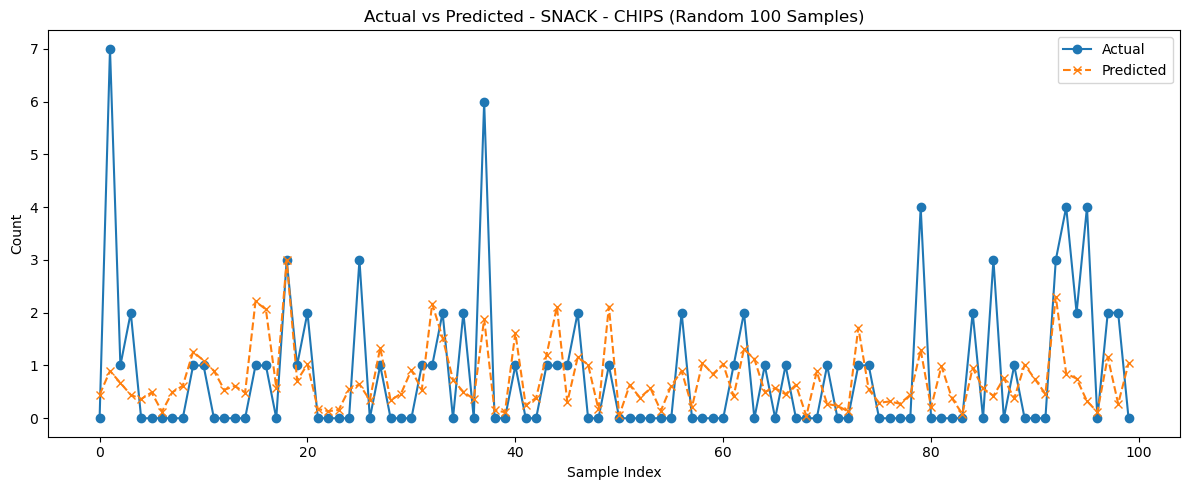

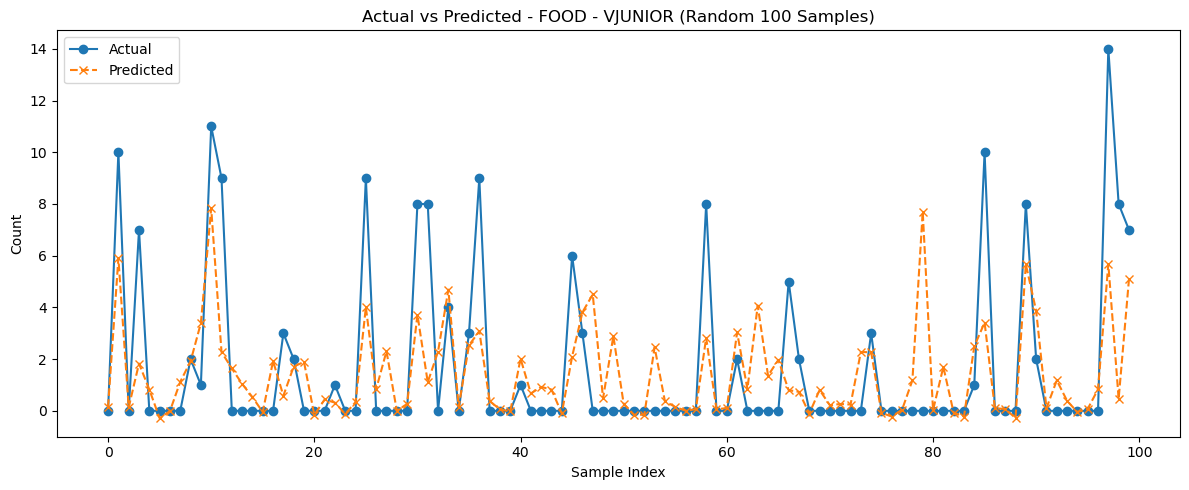

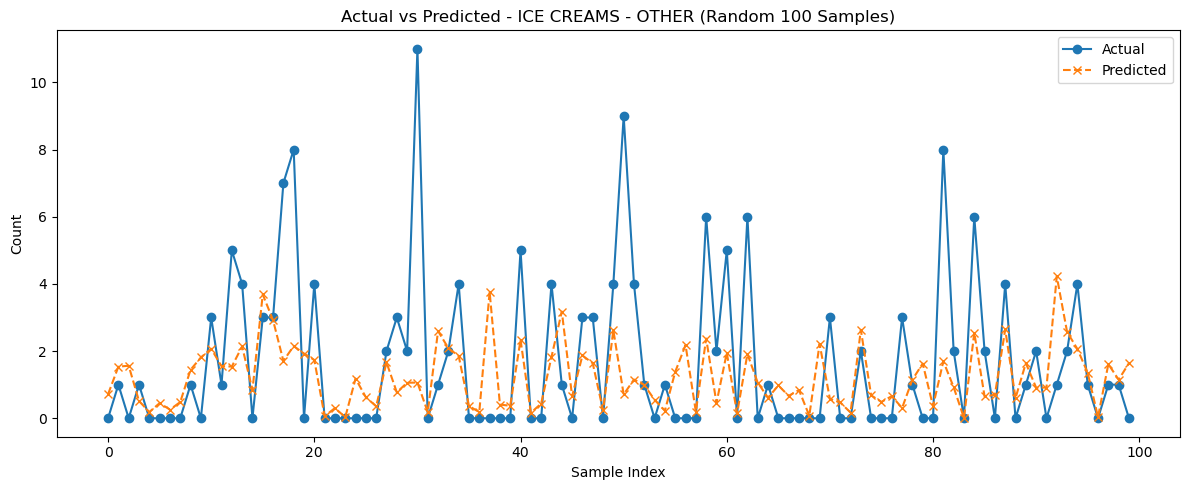

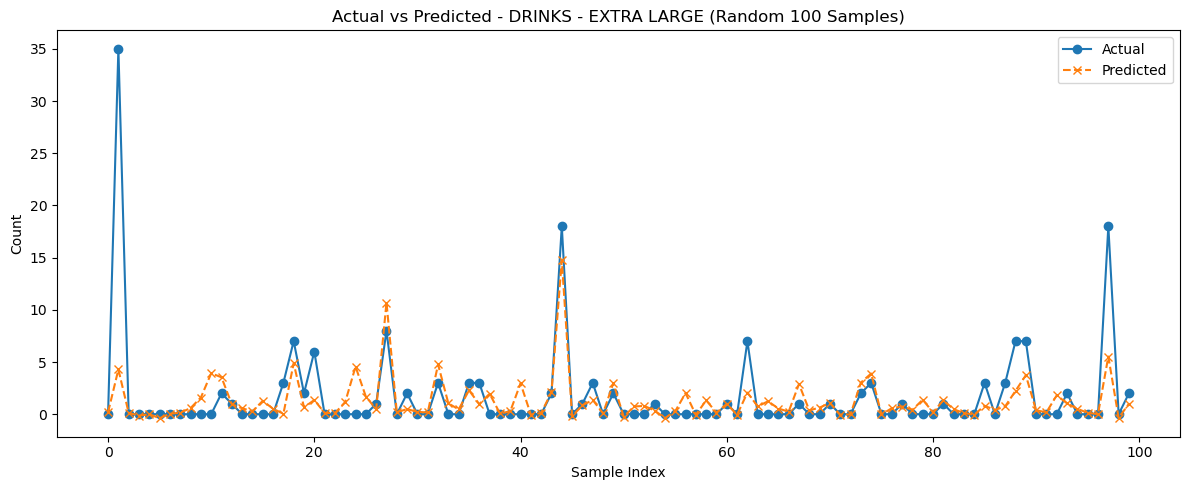

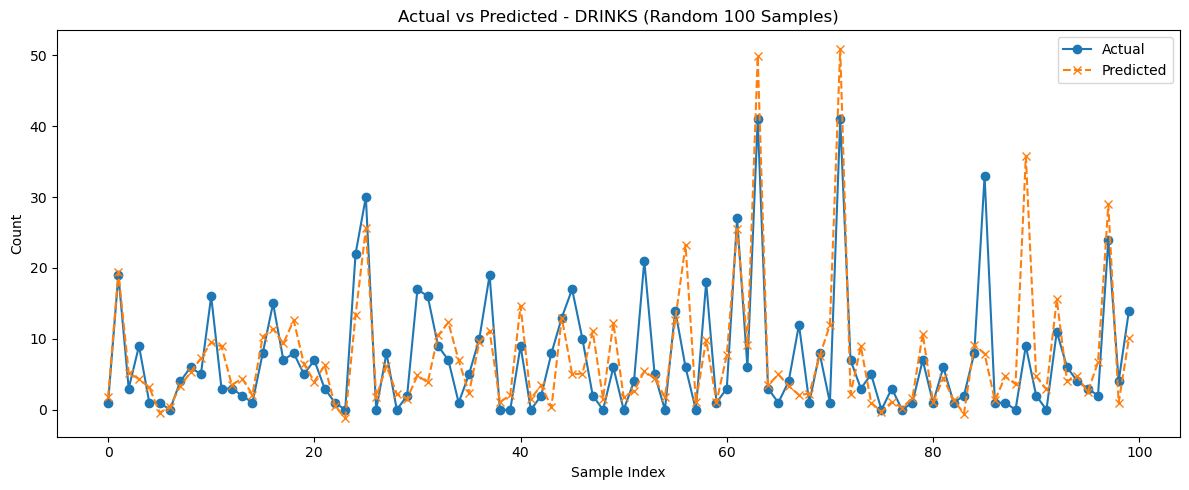

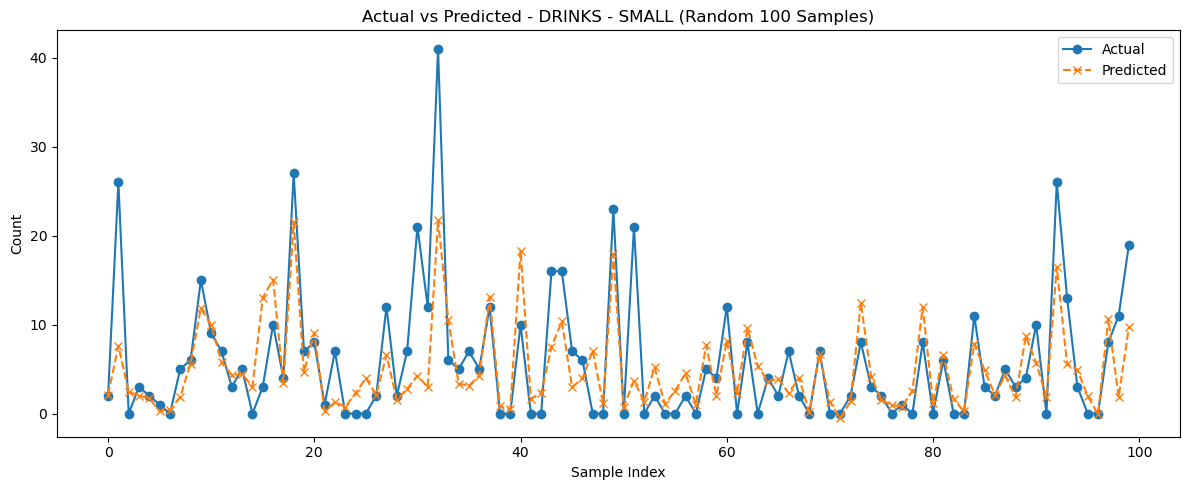

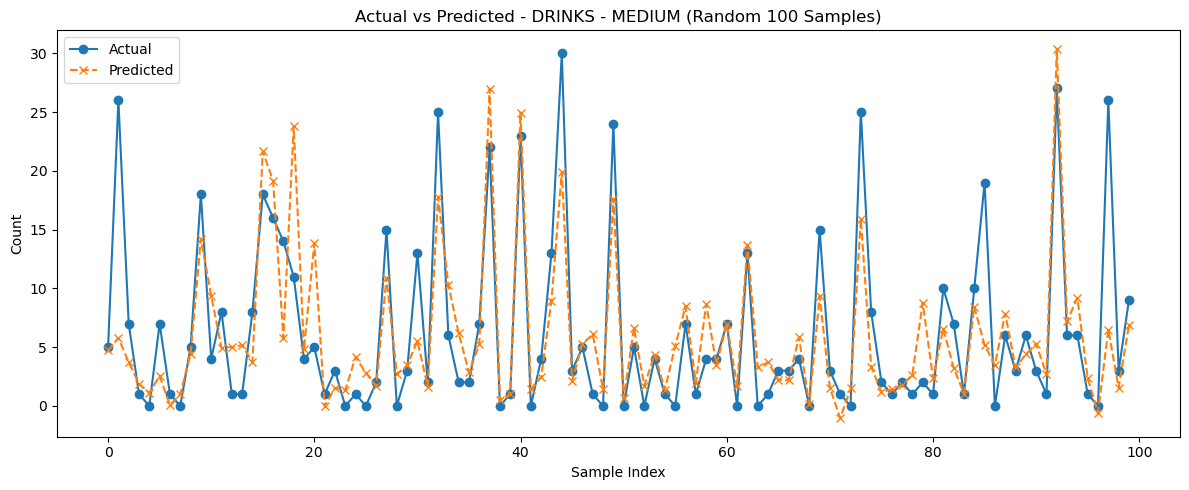

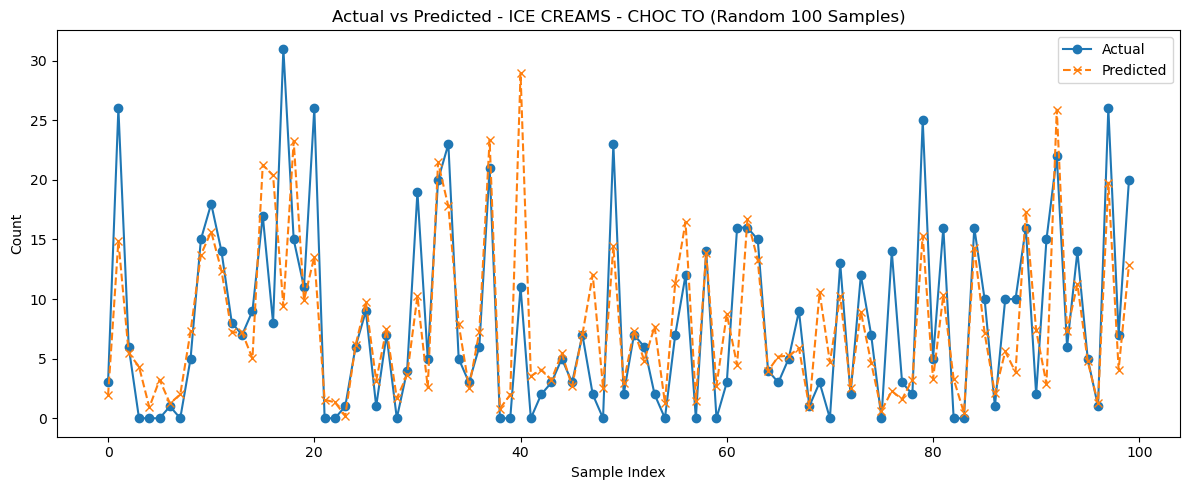

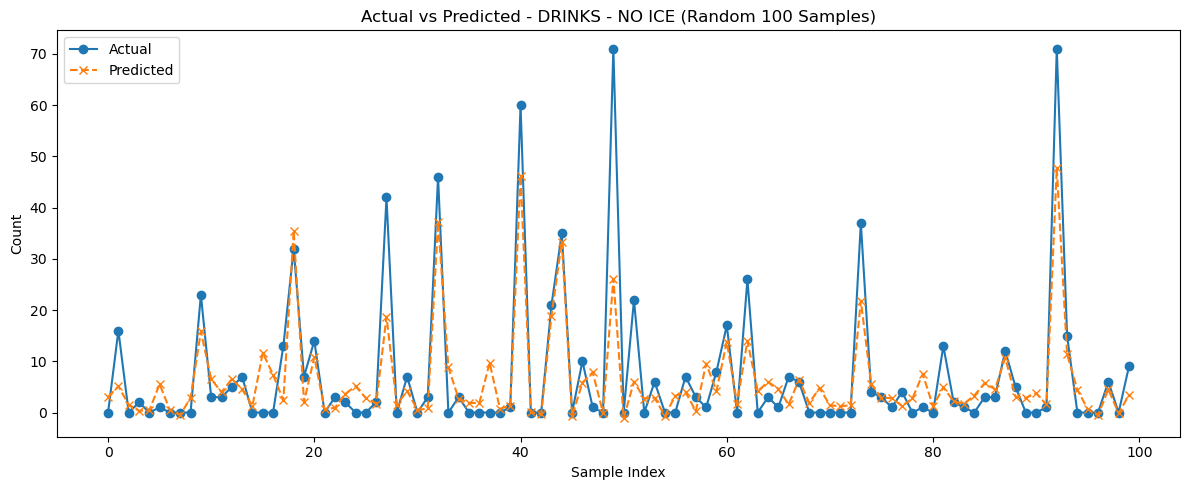

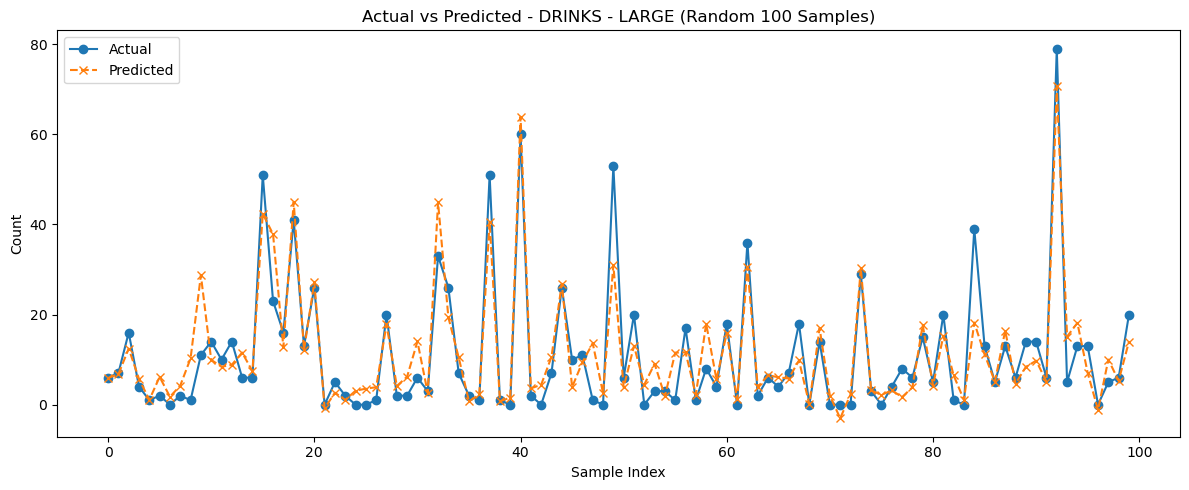

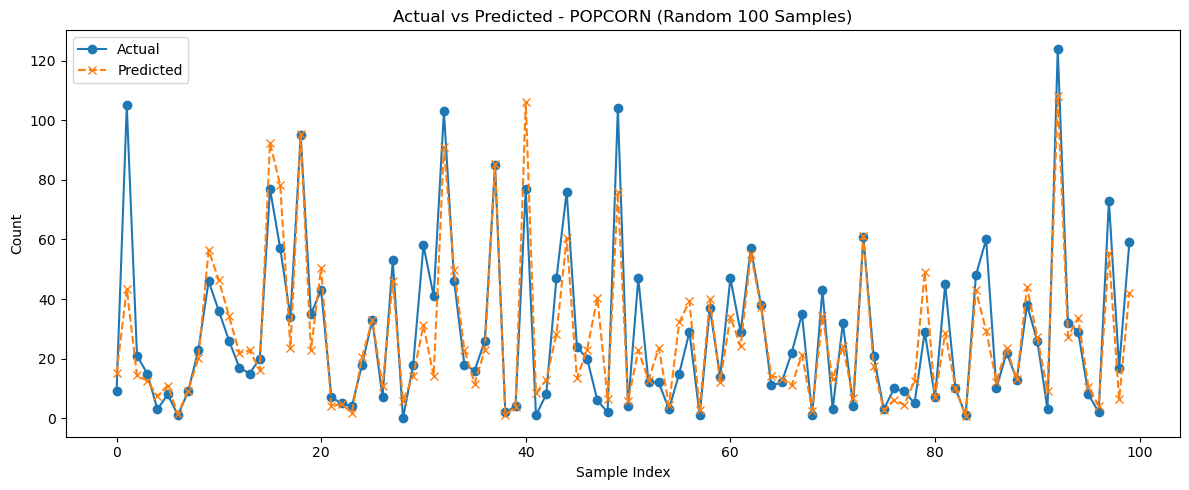

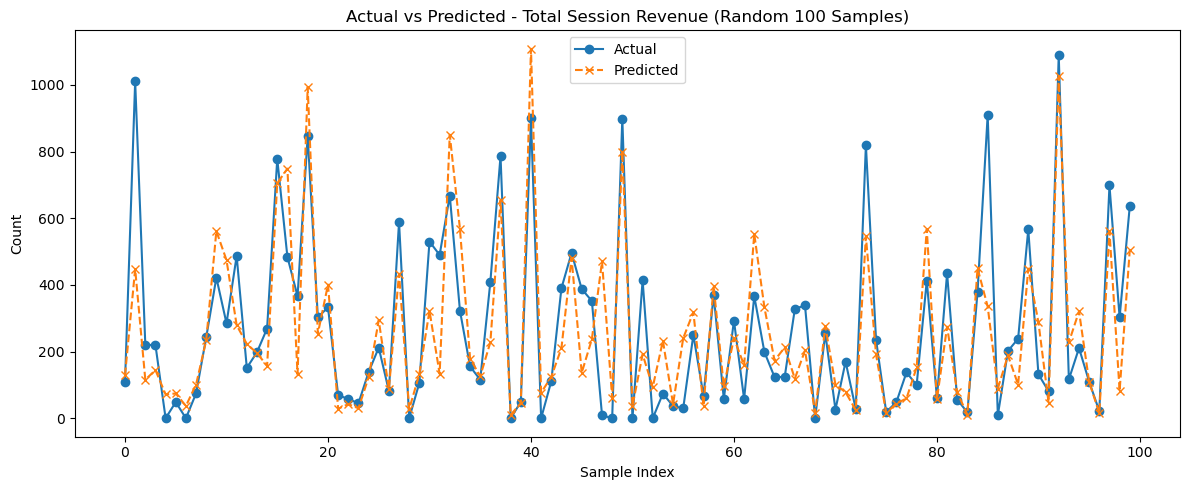

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reconstruct if needed:
# Y_test    = ...  # your test-set DataFrame
# Y_pred_df = ...  # your predictions DataFrame
# target_cols = [...]  # list of target column names

# Number of random samples
n_samples = 100
# Randomly pick indices
random_idx = np.random.choice(Y_test.shape[0], size=n_samples, replace=False)

for col in target_cols:
    actual = Y_test[col].values[random_idx]
    predicted = Y_pred_df[col].values[random_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted - {col} (Random {n_samples} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


### With Revenue details as feature in Catboost - Main Model

In [22]:
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# 1) Load data
basket_df = pd.read_csv("basketanalysis.csv")

# 2) Define features explicitly
feature_cols = [
    'Session Hour', 'Total Admits',
    'Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
    'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
    'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
    'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
    'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
    'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese',
    'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY',
    'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA',
    'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR',
    'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE',
    'Genre_SCI-FI', 'Genre_THRILLER', 'Genre_TO BE ADVISED',
    'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_MA15',
    'Rating_PG', 'Rating_R18+',
    'Duration_Short', 'Duration_Medium', 'Duration_Long',
    'DayOfWeek', 'Month','Total Session Revenue'
]

# 3) Define targets explicitly
target_cols = [
    'SNACK - CHIPS',
    'FOOD - VJUNIOR',
    'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE',
    'DRINKS',
    'DRINKS - SMALL',
    'DRINKS - MEDIUM',
    'ICE CREAMS - CHOC TO',
    'DRINKS - NO ICE',
    'DRINKS - LARGE',
    'POPCORN'
    
]

# 4) Subset and reorder the DataFrame
df_model = basket_df[feature_cols + target_cols].copy()

# 5) Split into features (X) and targets (Y)
X = df_model[feature_cols]
Y = df_model[target_cols]

# 6) Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 7) Build and train the CatBoost multi-output regressor
multi_cat = MultiOutputRegressor(
    CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        random_state=42,
        verbose=0
    )
)
multi_cat.fit(X_train, Y_train)

# 8) Predict on the test set
Y_pred = multi_cat.predict(X_test)
Y_pred_df = pd.DataFrame(Y_pred, columns=target_cols)

# 9) Evaluate: MAE and R² per item class
metrics = []
for col in target_cols:
    mae = mean_absolute_error(Y_test[col], Y_pred_df[col])
    r2  = r2_score(Y_test[col],  Y_pred_df[col])
    metrics.append({"Item Class": col, "MAE": mae, "R² Score": r2})

# 10) Create a DataFrame of results, sorted by MAE
results_df = pd.DataFrame(metrics).sort_values(by="MAE").reset_index(drop=True)

# 11) Display results
print(results_df)
import joblib

# 12) Persist the trained model and column lists
joblib.dump(multi_cat, "best_catboost_model_run3.pkl")
joblib.dump(feature_cols, "feature_cols_run3.pkl")
joblib.dump(target_cols, "target_cols_run3.pkl")

print("✅ Model saved to best_catboost_model_run3.pkl")
print("✅ Features list saved to feature_cols_run3.pkl")
print("✅ Targets list saved to target_cols_run3.pkl")

              Item Class       MAE  R² Score
0          SNACK - CHIPS  0.710831  0.219520
1         FOOD - VJUNIOR  0.980184  0.528483
2   DRINKS - EXTRA LARGE  1.053034  0.411762
3     ICE CREAMS - OTHER  1.180464  0.283966
4         DRINKS - SMALL  2.337418  0.615476
5        DRINKS - MEDIUM  2.583977  0.734411
6   ICE CREAMS - CHOC TO  3.321065  0.698010
7        DRINKS - NO ICE  3.463224  0.665529
8                 DRINKS  3.508094  0.703761
9         DRINKS - LARGE  3.802493  0.850617
10               POPCORN  5.282402  0.906604
✅ Model saved to best_catboost_model_run3.pkl
✅ Features list saved to feature_cols_run3.pkl
✅ Targets list saved to target_cols_run3.pkl


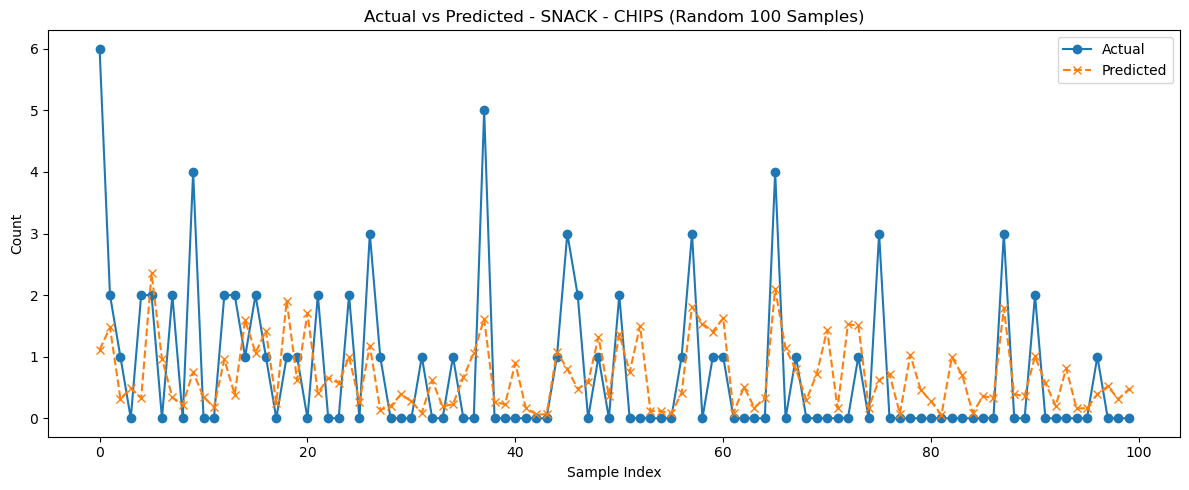

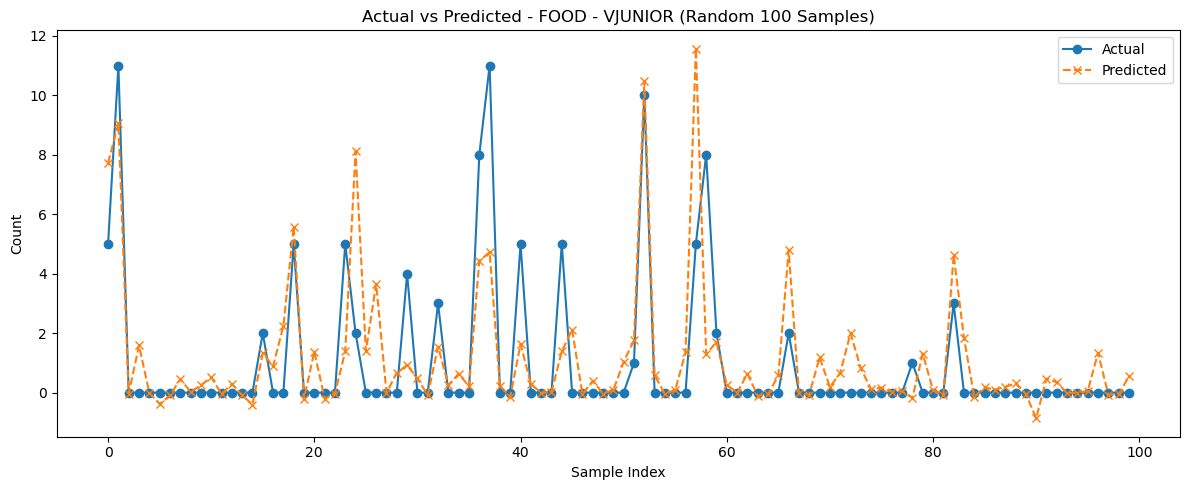

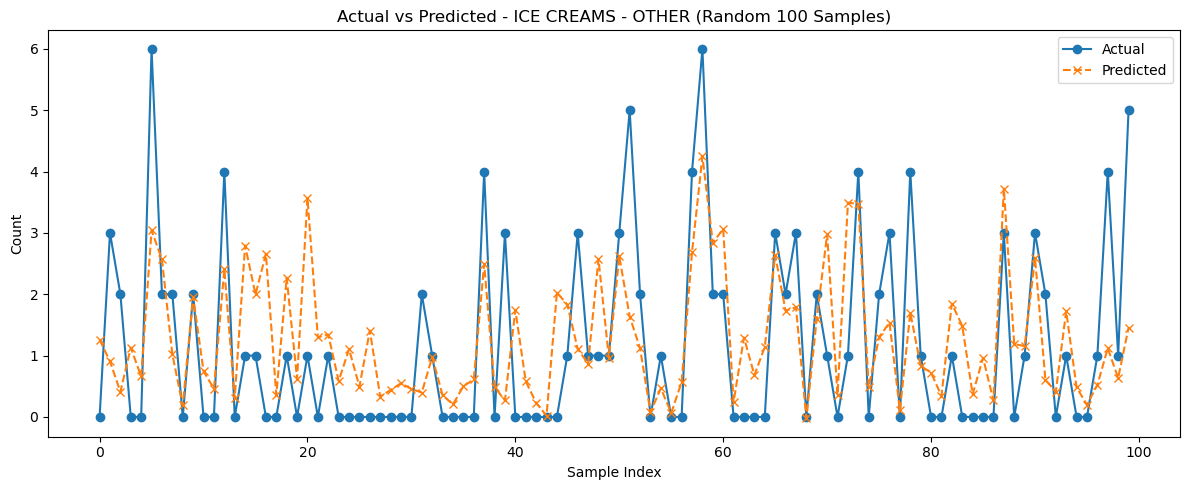

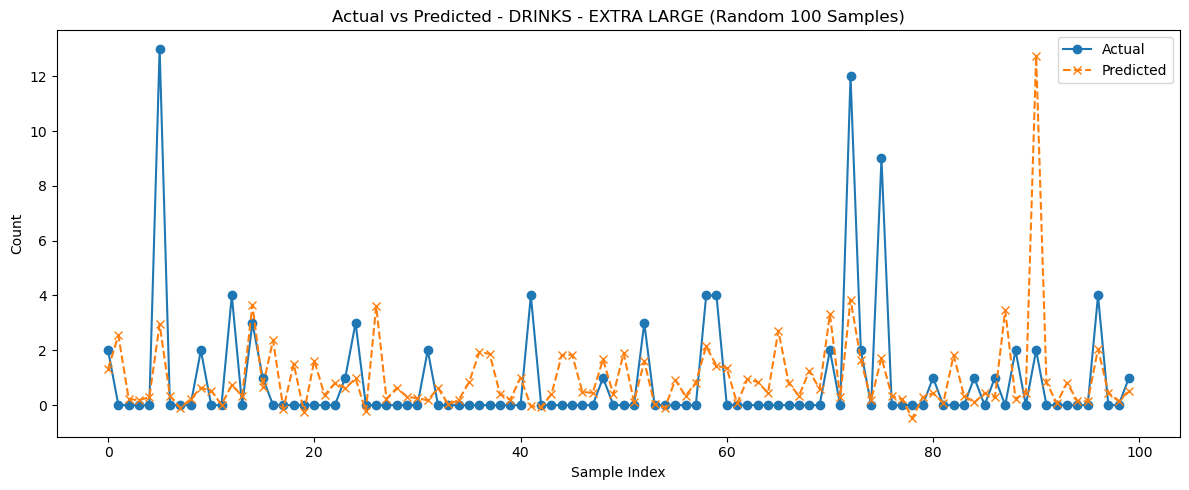

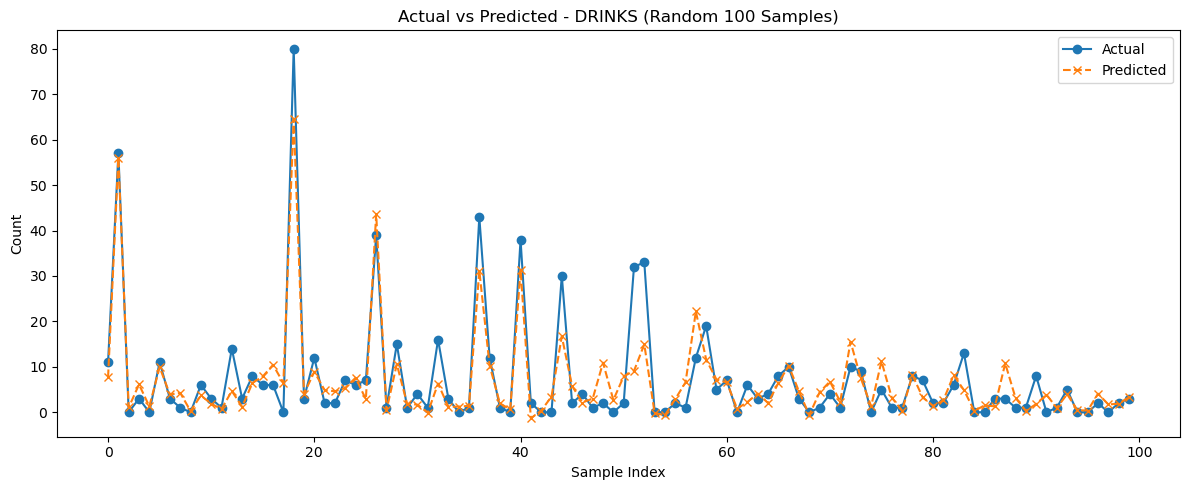

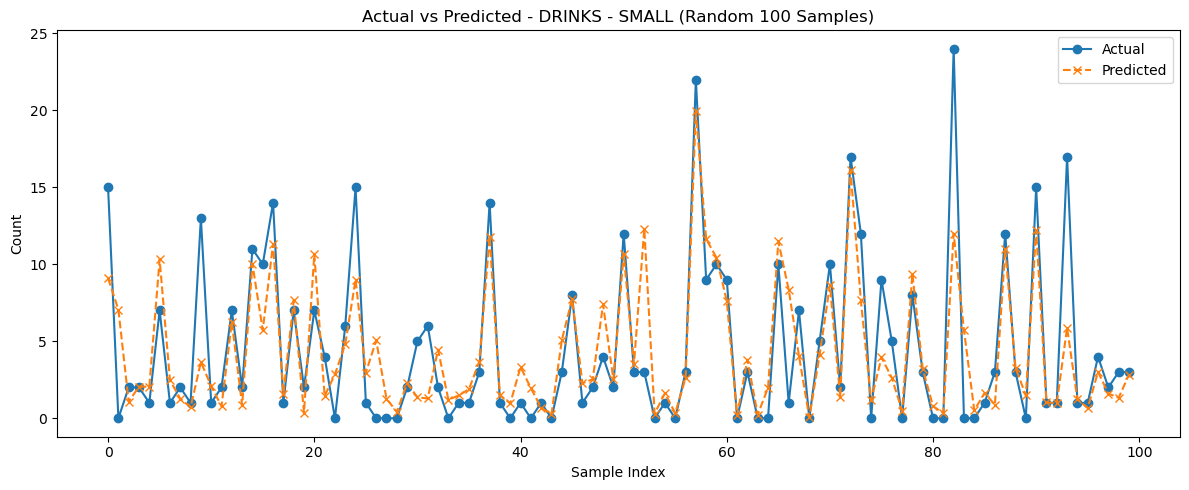

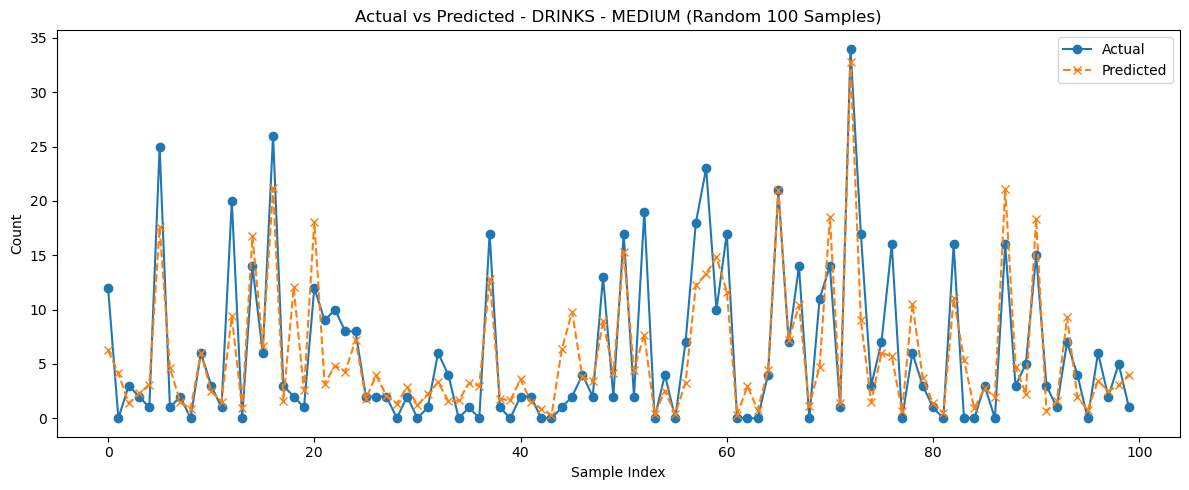

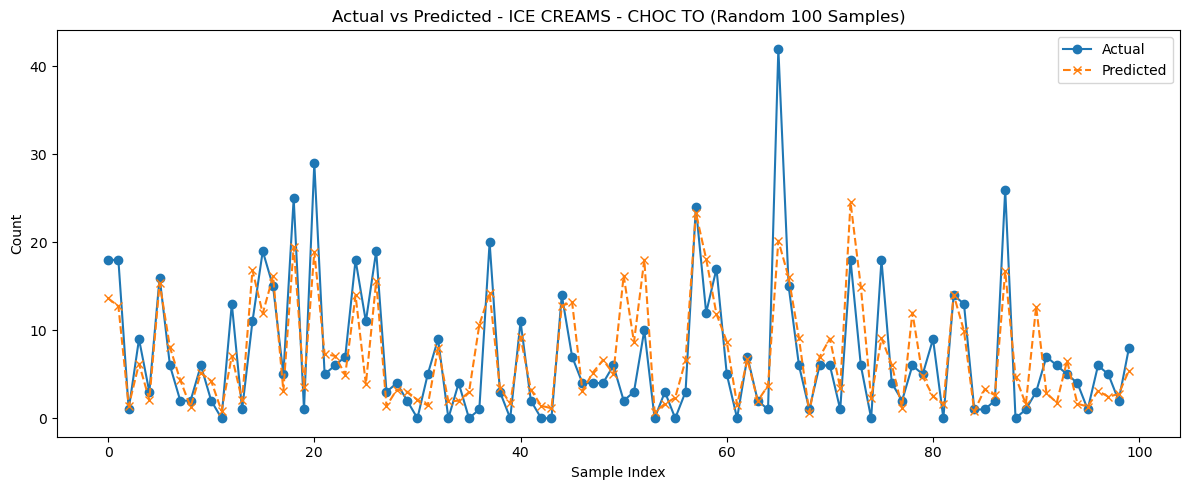

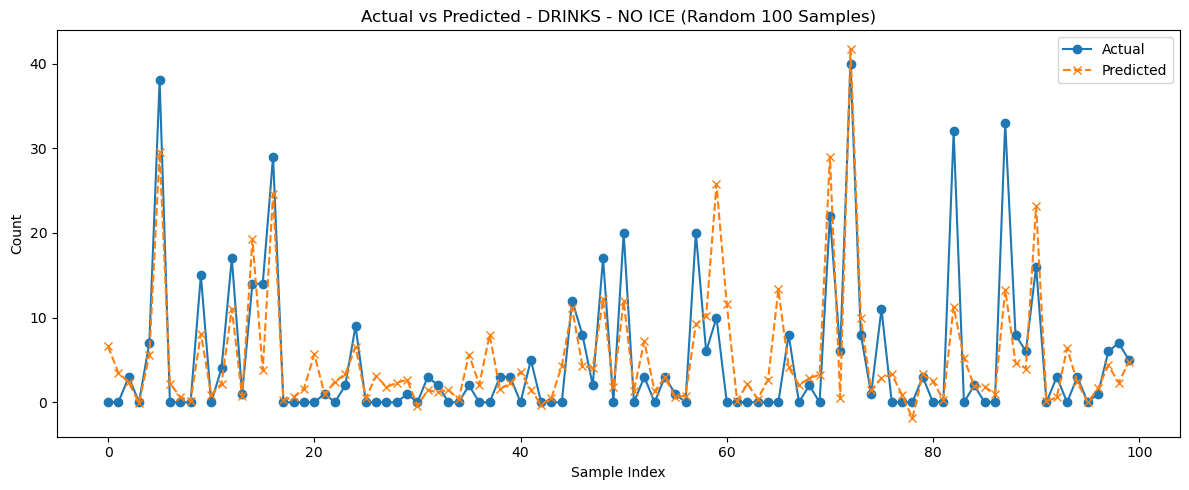

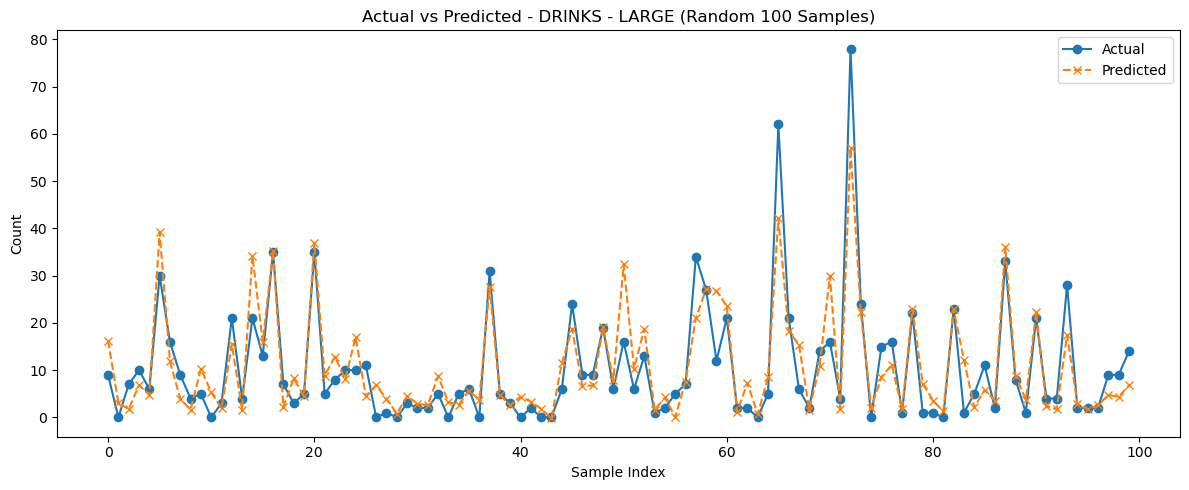

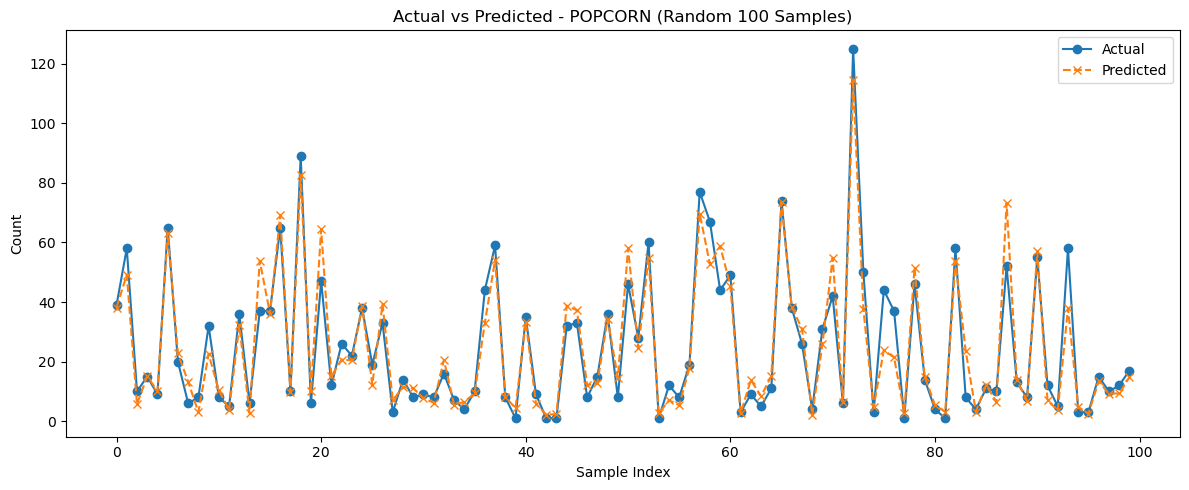

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reconstruct if needed:
# Y_test    = ...  # your test-set DataFrame
# Y_pred_df = ...  # your predictions DataFrame
# target_cols = [...]  # list of target column names

# Number of random samples
n_samples = 100
# Randomly pick indices
random_idx = np.random.choice(Y_test.shape[0], size=n_samples, replace=False)

for col in target_cols:
    actual = Y_test[col].values[random_idx]
    predicted = Y_pred_df[col].values[random_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted - {col} (Random {n_samples} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


### With Custom Bins

In [25]:
import pandas as pd

# 1) Load the basket analysis dataset and drop all-zero cols
basket_df = pd.read_csv("basketanalysis.csv")
basket_df.drop(columns=['POPCORN - PROMO', 'SNACK - OTHER'], inplace=True)

# 2) Explicitly define your feature and target columns
feature_cols = ['Session Date',
    'Session Hour', 'Total Admits',
    'Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
    'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
    'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
    'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
    'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
    'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese',
    'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY',
    'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA',
    'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR',
    'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE',
    'Genre_SCI-FI', 'Genre_THRILLER', 'Genre_TO BE ADVISED',
    'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_MA15',
    'Rating_PG', 'Rating_R18+',
    'Duration_Short', 'Duration_Medium', 'Duration_Long',
    'DayOfWeek', 'Month'
]
target_cols = [
    'SNACK - CHIPS', 'FOOD - VJUNIOR', 'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE', 'DRINKS', 'DRINKS - SMALL',
    'DRINKS - MEDIUM', 'ICE CREAMS - CHOC TO', 'DRINKS - NO ICE',
    'DRINKS - LARGE', 'POPCORN',
    'Total Session Revenue'
]

# 3) Subset and reorder the DataFrame so features come first, then targets
df_model = basket_df[feature_cols + target_cols].copy()

# Now df_model contains exactly your specified features and targets, in order


# 4) Bin session hours into time-of-day categories
def map_hour_to_bin(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_model['Session Time Bin'] = df_model['Session Hour'].apply(map_hour_to_bin)

# 5) Reorder so 'Session Time Bin' follows 'Session Hour'
cols = df_model.columns.tolist()
hour_idx = cols.index('Session Hour')
cols.remove('Session Time Bin')
cols.insert(hour_idx + 1, 'Session Time Bin')
df_model = df_model[cols]

# 6) Drop the original 'Session Hour'
df_model.drop(columns=['Session Hour'], inplace=True)

# 7) Aggregate by date & time bin, summing numeric features
aggregated_df = (
    df_model
    .groupby(['Session Date', 'Session Time Bin'], as_index=False)
    .sum()
)

# 8) One-hot encode the time bin
original_cols = aggregated_df.columns.tolist()
bin_idx = original_cols.index('Session Time Bin')
dummies = pd.get_dummies(aggregated_df['Session Time Bin'], prefix='TimeBin')
aggregated_df.drop(columns=['Session Time Bin'], inplace=True)

# Insert dummy columns at the same position
for i, col in enumerate(dummies.columns):
    aggregated_df.insert(bin_idx + i, col, dummies[col])


In [26]:
aggregated_df.columns

Index(['Session Date', 'TimeBin_Afternoon', 'TimeBin_Evening',
       'TimeBin_Morning', 'TimeBin_Night', 'Total Admits', 'Lang_Assamese',
       'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
       'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
       'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
       'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
       'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
       'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese', 'Genre_ACTION',
       'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY', 'Genre_COMEDY',
       'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA', 'Genre_FAMILY',
       'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR', 'Genre_MUSIC',
       'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE', 'Genre_SCI-FI',
       'Genre_THRILLER', 'Genre_TO BE ADVISED', 'Rating_CTC', 'Rating_E',
       'Rating_G', 'Rating_M', 'Rating_MA15', 'Ra

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# 1) Use preprocessed DataFrame
df = aggregated_df.copy()

# 2) Define features and targets
feature_cols = [
    'TimeBin_Afternoon', 'TimeBin_Evening',
    'TimeBin_Morning', 'TimeBin_Night', 'Total Admits',
    'Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
    'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
    'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
    'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
    'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
    'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese',
    'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY',
    'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA',
    'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR',
    'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE',
    'Genre_SCI-FI', 'Genre_THRILLER', 'Genre_TO BE ADVISED',
    'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_MA15',
    'Rating_PG', 'Rating_R18+',
    'Duration_Short', 'Duration_Medium', 'Duration_Long',
    'DayOfWeek', 'Month', 'Total Session Revenue'
]
target_cols = [
    'SNACK - CHIPS', 'FOOD - VJUNIOR', 'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE', 'DRINKS', 'DRINKS - SMALL',
    'DRINKS - MEDIUM', 'ICE CREAMS - CHOC TO', 'DRINKS - NO ICE',
    'DRINKS - LARGE', 'POPCORN'
]

X = df[feature_cols]
Y = df[target_cols]

# 3) Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 4) Set up MultiOutputRegressor with CatBoost base
base_cb = CatBoostRegressor(
    random_state=42,
    verbose=0
)
multi_cat = MultiOutputRegressor(base_cb)

# 5) Smaller hyperparameter search space
param_dist = {
    'estimator__iterations': [200, 500],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__depth': [6, 8],
    'estimator__l2_leaf_reg': [3, 5],
    'estimator__bagging_temperature': [0, 0.5]
}

search = RandomizedSearchCV(
    multi_cat,
    param_distributions=param_dist,
    n_iter=6,               # fewer trials
    scoring='neg_root_mean_squared_error',
    cv=2,                   # fewer folds
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 6) Run tuning
search.fit(X_train, Y_train)

# 7) Best model
best_model = search.best_estimator_
print("✅ Best params:", search.best_params_)

# 8) Evaluate on test
Y_pred = best_model.predict(X_test)
metrics = []
for i, col in enumerate(target_cols):
    mae = mean_absolute_error(Y_test[col], Y_pred[:, i])
    r2  = r2_score(Y_test[col], Y_pred[:, i])
    metrics.append({'Item Class': col, 'MAE': mae, 'R²': r2})

metrics_df = pd.DataFrame(metrics).sort_values('MAE').reset_index(drop=True)
print(metrics_df)

# # 9) Save model & columns
# joblib.dump(best_model, "multi_catboost_model_light.pkl")
# joblib.dump(feature_cols, "feature_cols.pkl")
# joblib.dump(target_cols, "target_cols.pkl")
# print("✅ Saved lightweight model and column lists.")


Fitting 2 folds for each of 6 candidates, totalling 12 fits
✅ Best params: {'estimator__learning_rate': 0.1, 'estimator__l2_leaf_reg': 3, 'estimator__iterations': 200, 'estimator__depth': 6, 'estimator__bagging_temperature': 0.5}
              Item Class       MAE        R²
0          SNACK - CHIPS  1.379173  0.528558
1         FOOD - VJUNIOR  2.141052  0.618457
2     ICE CREAMS - OTHER  2.188222  0.589577
3   DRINKS - EXTRA LARGE  2.449944  0.665286
4         DRINKS - SMALL  4.650942  0.834800
5        DRINKS - MEDIUM  4.966086  0.882414
6   ICE CREAMS - CHOC TO  6.080523  0.878536
7         DRINKS - LARGE  7.406060  0.934412
8                 DRINKS  7.835475  0.831360
9        DRINKS - NO ICE  8.144090  0.789404
10               POPCORN  9.358797  0.972787


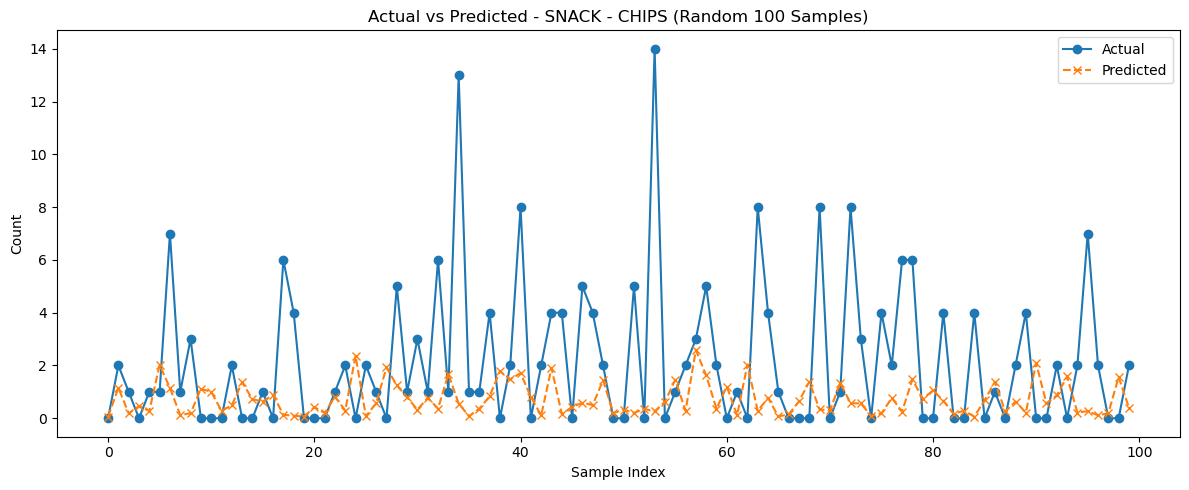

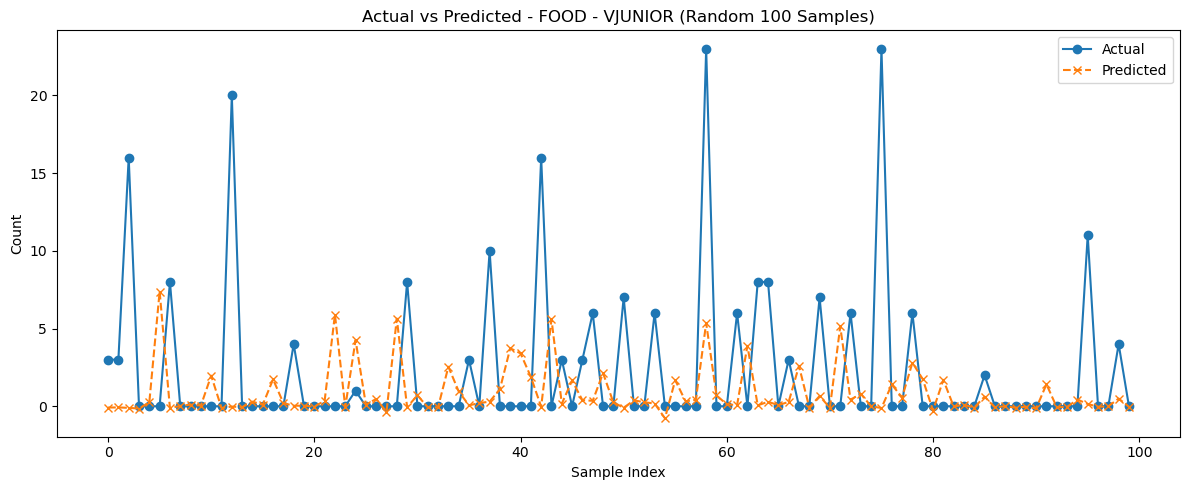

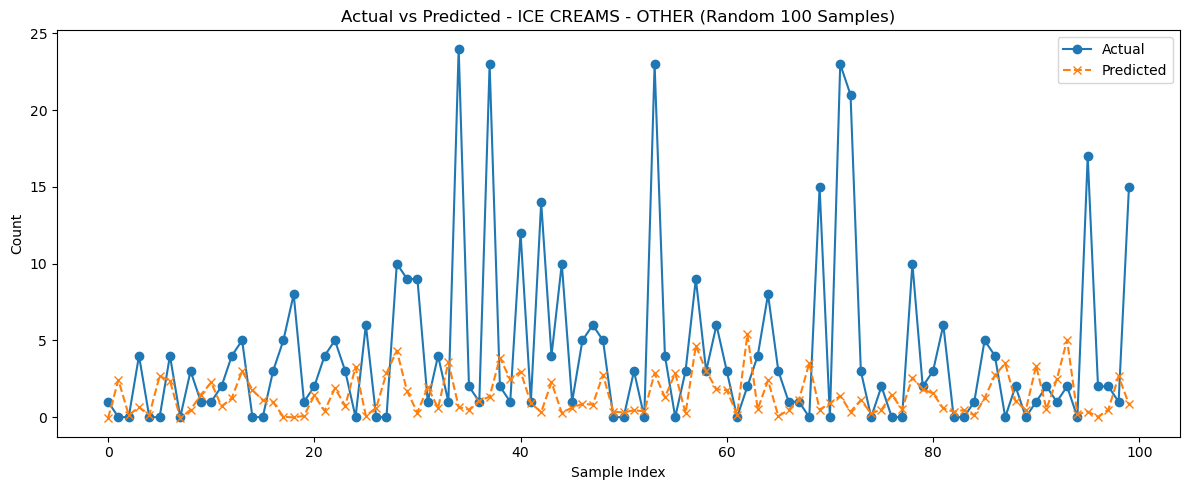

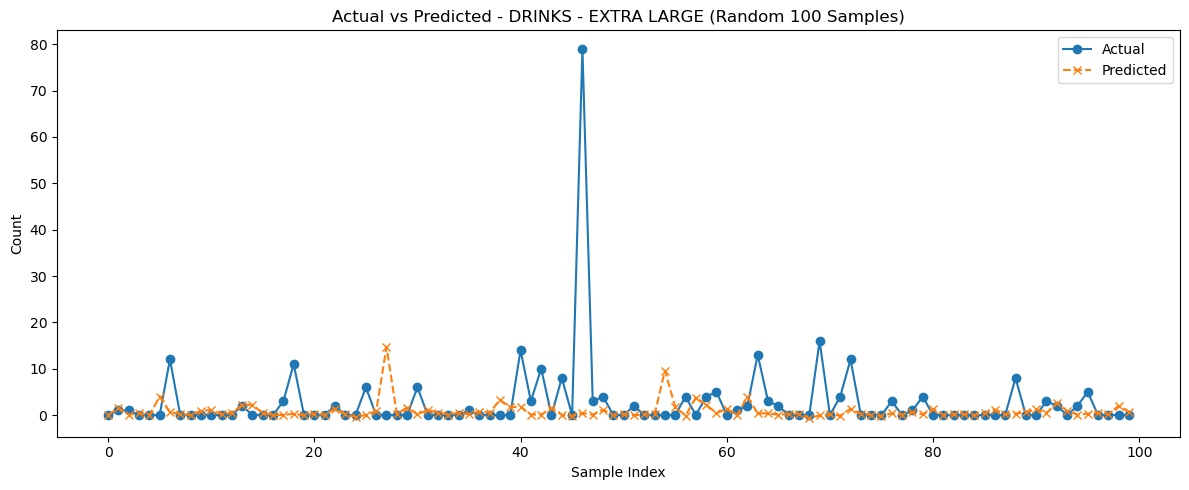

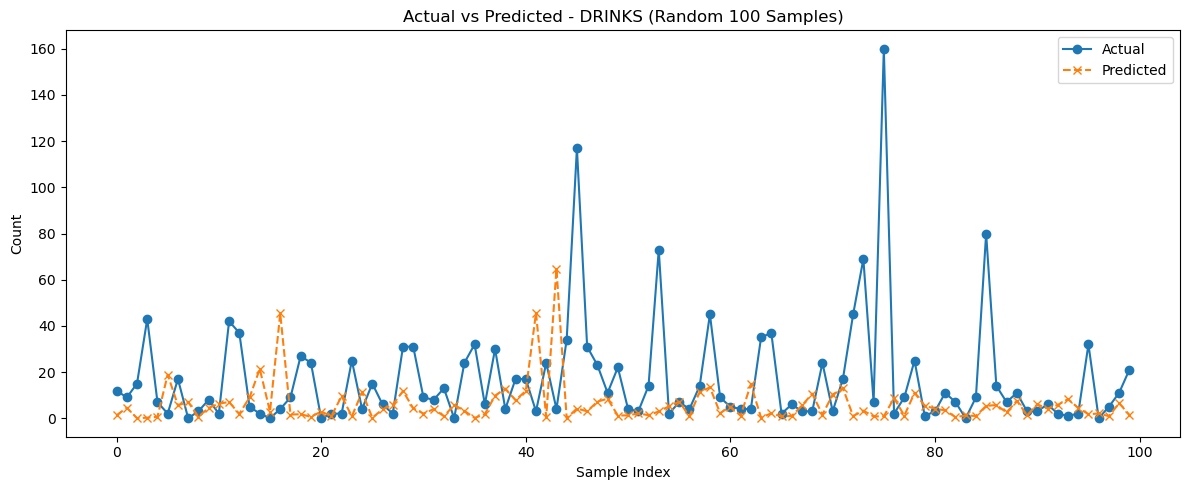

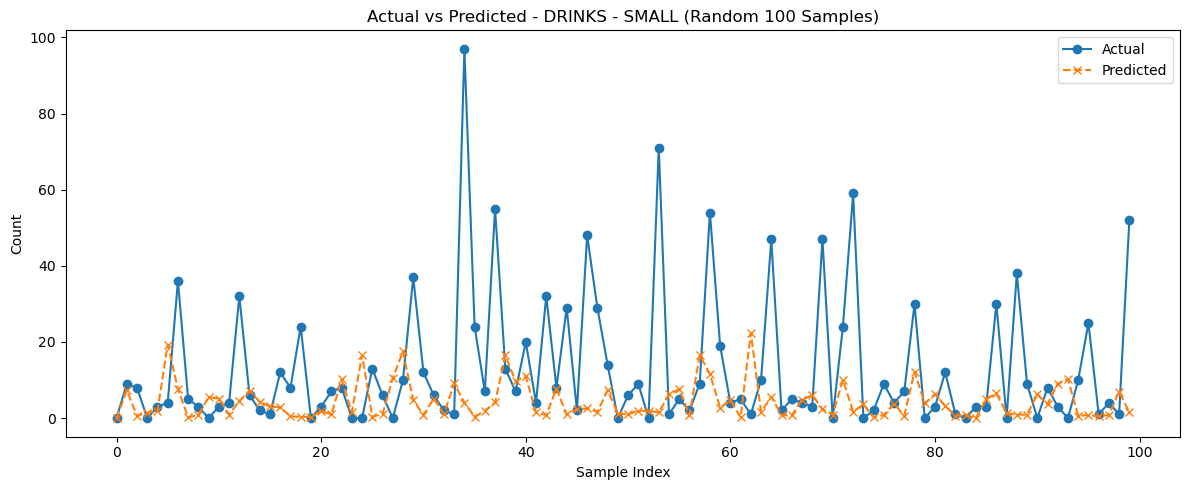

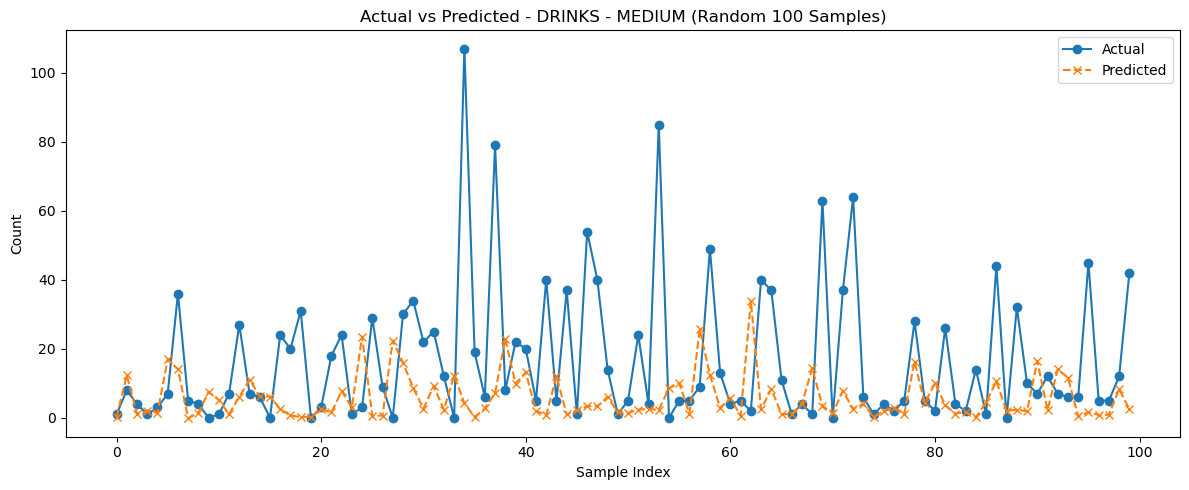

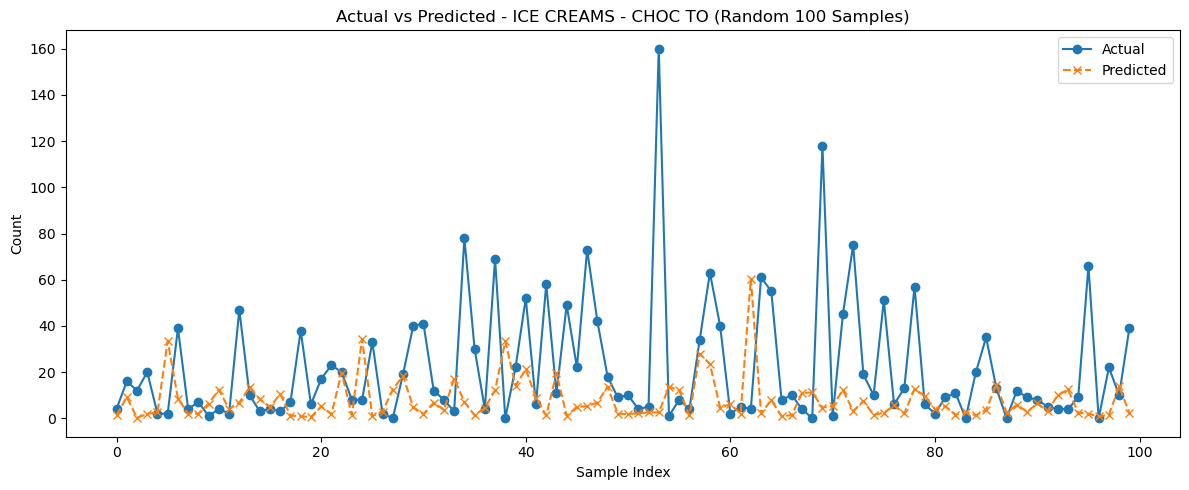

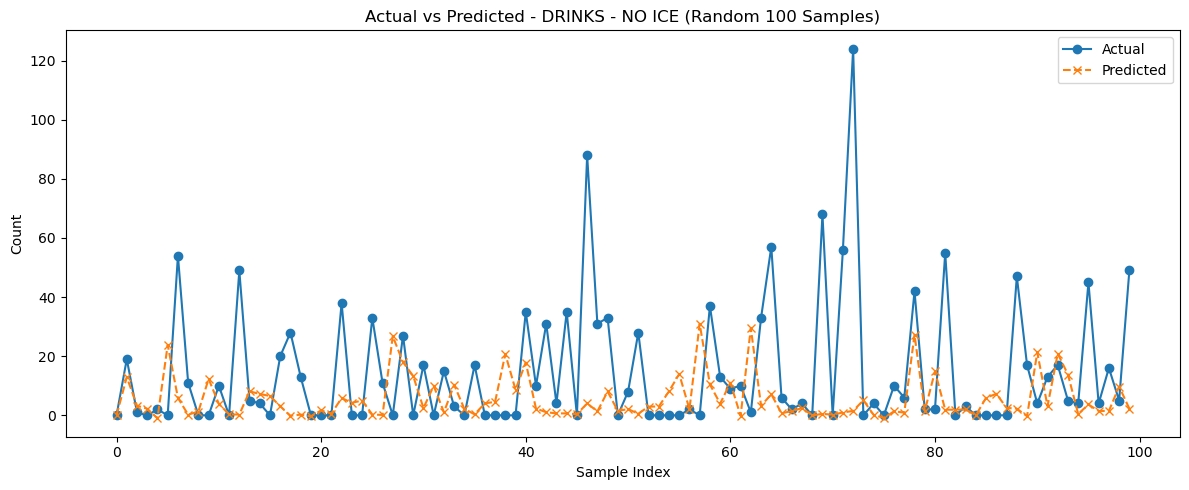

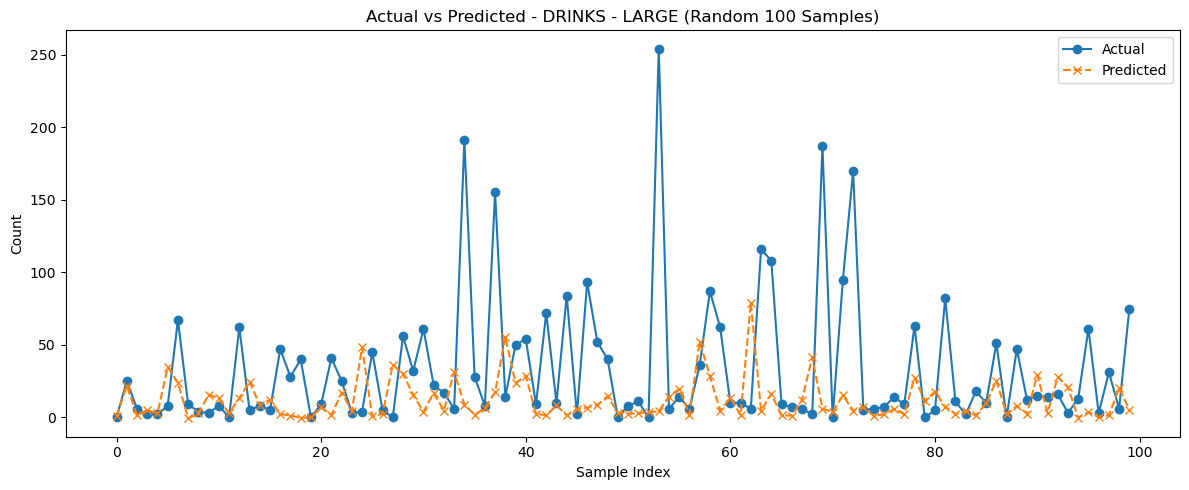

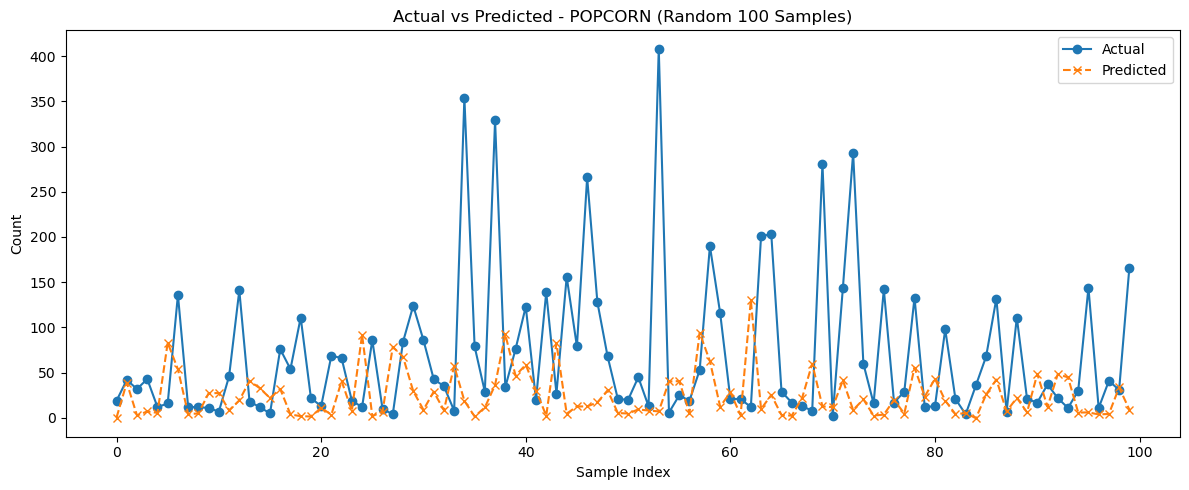

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reconstruct if needed:
# Y_test    = ...  # your test-set DataFrame
# Y_pred_df = ...  # your predictions DataFrame
# target_cols = [...]  # list of target column names

# Number of random samples
n_samples = 100
# Randomly pick indices
random_idx = np.random.choice(Y_test.shape[0], size=n_samples, replace=False)

for col in target_cols:
    actual = Y_test[col].values[random_idx]
    predicted = Y_pred_df[col].values[random_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted - {col} (Random {n_samples} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Preprocessing for Kajols bins

In [30]:
import pandas as pd

# 1) Load the basket analysis dataset and drop all-zero cols
basket_df = pd.read_csv("basketanalysis.csv")
basket_df.drop(columns=['POPCORN - PROMO', 'SNACK - OTHER'], inplace=True)

# 2) Explicitly define your feature and target columns
feature_cols = ['Session Date',
    'Session Hour', 'Total Admits',
    'Lang_Assamese', 'Lang_Bengali', 'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)',
    'Lang_English', 'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi',
    'Lang_Indonesian', 'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean',
    'Lang_Malayalam', 'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles',
    'Lang_Not assigned', 'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu',
    'Lang_Thai', 'Lang_Urdu', 'Lang_Vietnamese',
    'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION', 'Genre_BIOGRAPHY',
    'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY', 'Genre_DRAMA',
    'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING', 'Genre_HORROR',
    'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY', 'Genre_ROMANCE',
    'Genre_SCI-FI', 'Genre_THRILLER', 'Genre_TO BE ADVISED',
    'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M', 'Rating_MA15',
    'Rating_PG', 'Rating_R18+',
    'Duration_Short', 'Duration_Medium', 'Duration_Long',
    'DayOfWeek', 'Month'
]
target_cols = [
    'SNACK - CHIPS', 'FOOD - VJUNIOR', 'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE', 'DRINKS', 'DRINKS - SMALL',
    'DRINKS - MEDIUM', 'ICE CREAMS - CHOC TO', 'DRINKS - NO ICE',
    'DRINKS - LARGE', 'POPCORN',
    'Total Session Revenue'
]

# 3) Subset and reorder the DataFrame so features come first, then targets
df_model = basket_df[feature_cols + target_cols].copy()

# Now df_model contains exactly your specified features and targets, in order
# Define the precise slot windows (hours only)
SLOT_WINDOWS = {
    'morning':      (9, 11),   # 09:00–11:00
    'early_noon':   (11, 13),  # 11:00–13:00
    'noon':         (13, 15),  # 13:00–15:00
    'late_noon':    (15, 17),  # 15:00–17:00
    'evening_1':    (17, 18),  # 17:00–18:00
    'evening_2':    (18, 19),  # 18:00–19:00
    'evening_3':    (19, 20),  # 19:00–20:00
    'evening_4':    (20, 21),  # 20:00–21:00
    'night':        (21, 24),  # 21:00–24:00
}

def map_hour_to_bin(hour: int) -> str:
    """
    Map an integer hour (0–23) to a named time slot.
    Defaults to 'night' if the hour falls outside specified ranges.
    """
    for slot, (start, end) in SLOT_WINDOWS.items():
        if start <= hour < end:
            return slot
    return 'night'

df_model['Session Time Bin'] = df_model['Session Hour'].apply(map_hour_to_bin)

# 5) Reorder so 'Session Time Bin' follows 'Session Hour'
cols = df_model.columns.tolist()
hour_idx = cols.index('Session Hour')
cols.remove('Session Time Bin')
cols.insert(hour_idx + 1, 'Session Time Bin')
df_model = df_model[cols]

# 6) Drop the original 'Session Hour'
df_model.drop(columns=['Session Hour'], inplace=True)

# 7) Aggregate by date & time bin, summing numeric features
aggregated_df = (
    df_model
    .groupby(['Session Date', 'Session Time Bin'], as_index=False)
    .sum()
)

# 8) One-hot encode the time bin
original_cols = aggregated_df.columns.tolist()
bin_idx = original_cols.index('Session Time Bin')
dummies = pd.get_dummies(aggregated_df['Session Time Bin'], prefix='TimeBin')
aggregated_df.drop(columns=['Session Time Bin'], inplace=True)

# Insert dummy columns at the same position
for i, col in enumerate(dummies.columns):
    aggregated_df.insert(bin_idx + i, col, dummies[col])


In [31]:
 aggregated_df.columns

Index(['Session Date', 'TimeBin_early_noon', 'TimeBin_evening_1',
       'TimeBin_evening_2', 'TimeBin_evening_3', 'TimeBin_evening_4',
       'TimeBin_late_noon', 'TimeBin_morning', 'TimeBin_night', 'TimeBin_noon',
       'Total Admits', 'Lang_Assamese', 'Lang_Bengali',
       'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)', 'Lang_English',
       'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi', 'Lang_Indonesian',
       'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean', 'Lang_Malayalam',
       'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles', 'Lang_Not assigned',
       'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu', 'Lang_Thai', 'Lang_Urdu',
       'Lang_Vietnamese', 'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION',
       'Genre_BIOGRAPHY', 'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY',
       'Genre_DRAMA', 'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING',
       'Genre_HORROR', 'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY',
       'Genre_ROMANCE', 'Genre_SCI-FI', 'Genre

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# 1) Use preprocessed DataFrame
df = aggregated_df.copy()

# 2) Define features and targets
feature_cols = ['TimeBin_early_noon', 'TimeBin_evening_1',
       'TimeBin_evening_2', 'TimeBin_evening_3', 'TimeBin_evening_4',
       'TimeBin_late_noon', 'TimeBin_morning', 'TimeBin_night', 'TimeBin_noon',
       'Total Admits', 'Lang_Assamese', 'Lang_Bengali',
       'Lang_Chinese (Cantonese)', 'Lang_Chinese (Mandarin)', 'Lang_English',
       'Lang_Filipino', 'Lang_Gujarati', 'Lang_Hindi', 'Lang_Indonesian',
       'Lang_Japanese', 'Lang_Kannada', 'Lang_Korean', 'Lang_Malayalam',
       'Lang_Maori', 'Lang_Nepali', 'Lang_No Subtitles', 'Lang_Not assigned',
       'Lang_Punjabi', 'Lang_Tamil', 'Lang_Telugu', 'Lang_Thai', 'Lang_Urdu',
       'Lang_Vietnamese', 'Genre_ACTION', 'Genre_ADVENTURE', 'Genre_ANIMATION',
       'Genre_BIOGRAPHY', 'Genre_COMEDY', 'Genre_CRIME', 'Genre_DOCUMENTARY',
       'Genre_DRAMA', 'Genre_FAMILY', 'Genre_FANTASY', 'Genre_GAMING',
       'Genre_HORROR', 'Genre_MUSIC', 'Genre_MUSICAL', 'Genre_MYSTERY',
       'Genre_ROMANCE', 'Genre_SCI-FI', 'Genre_THRILLER',
       'Genre_TO BE ADVISED', 'Rating_CTC', 'Rating_E', 'Rating_G', 'Rating_M',
       'Rating_MA15', 'Rating_PG', 'Rating_R18+', 'Duration_Short',
       'Duration_Medium', 'Duration_Long', 'DayOfWeek', 'Month', 'Total Session Revenue'
]
target_cols = [
    'SNACK - CHIPS', 'FOOD - VJUNIOR', 'ICE CREAMS - OTHER',
    'DRINKS - EXTRA LARGE', 'DRINKS', 'DRINKS - SMALL',
    'DRINKS - MEDIUM', 'ICE CREAMS - CHOC TO', 'DRINKS - NO ICE',
    'DRINKS - LARGE', 'POPCORN'
]

X = df[feature_cols]
Y = df[target_cols]

# 3) Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# 4) Set up MultiOutputRegressor with CatBoost base
base_cb = CatBoostRegressor(
    random_state=42,
    verbose=0
)
multi_cat = MultiOutputRegressor(base_cb)

# 5) Smaller hyperparameter search space
param_dist = {
    'estimator__iterations': [200, 500],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__depth': [6, 8],
    'estimator__l2_leaf_reg': [3, 5],
    'estimator__bagging_temperature': [0, 0.5]
}

search = RandomizedSearchCV(
    multi_cat,
    param_distributions=param_dist,
    n_iter=6,               # fewer trials
    scoring='neg_root_mean_squared_error',
    cv=2,                   # fewer folds
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 6) Run tuning
search.fit(X_train, Y_train)

# 7) Best model
best_model = search.best_estimator_
print("✅ Best params:", search.best_params_)

# 8) Evaluate on test
Y_pred = best_model.predict(X_test)
metrics = []
for i, col in enumerate(target_cols):
    mae = mean_absolute_error(Y_test[col], Y_pred[:, i])
    r2  = r2_score(Y_test[col], Y_pred[:, i])
    metrics.append({'Item Class': col, 'MAE': mae, 'R²': r2})

metrics_df = pd.DataFrame(metrics).sort_values('MAE').reset_index(drop=True)
print(metrics_df)

# # 9) Save model & columns
# joblib.dump(best_model, "multi_catboost_model_light.pkl")
# joblib.dump(feature_cols, "feature_cols.pkl")
# joblib.dump(target_cols, "target_cols.pkl")
# print("✅ Saved lightweight model and column lists.")


Fitting 2 folds for each of 6 candidates, totalling 12 fits
✅ Best params: {'estimator__learning_rate': 0.1, 'estimator__l2_leaf_reg': 3, 'estimator__iterations': 500, 'estimator__depth': 8, 'estimator__bagging_temperature': 0.5}
              Item Class       MAE        R²
0          SNACK - CHIPS  0.882753  0.230749
1         FOOD - VJUNIOR  1.176366  0.666296
2   DRINKS - EXTRA LARGE  1.411388  0.453569
3     ICE CREAMS - OTHER  1.465114  0.260171
4         DRINKS - SMALL  2.901062  0.701636
5        DRINKS - MEDIUM  3.300903  0.717171
6   ICE CREAMS - CHOC TO  4.089160  0.755364
7                 DRINKS  4.267997  0.700343
8        DRINKS - NO ICE  4.300815  0.657682
9         DRINKS - LARGE  5.076743  0.831231
10               POPCORN  6.803793  0.908499


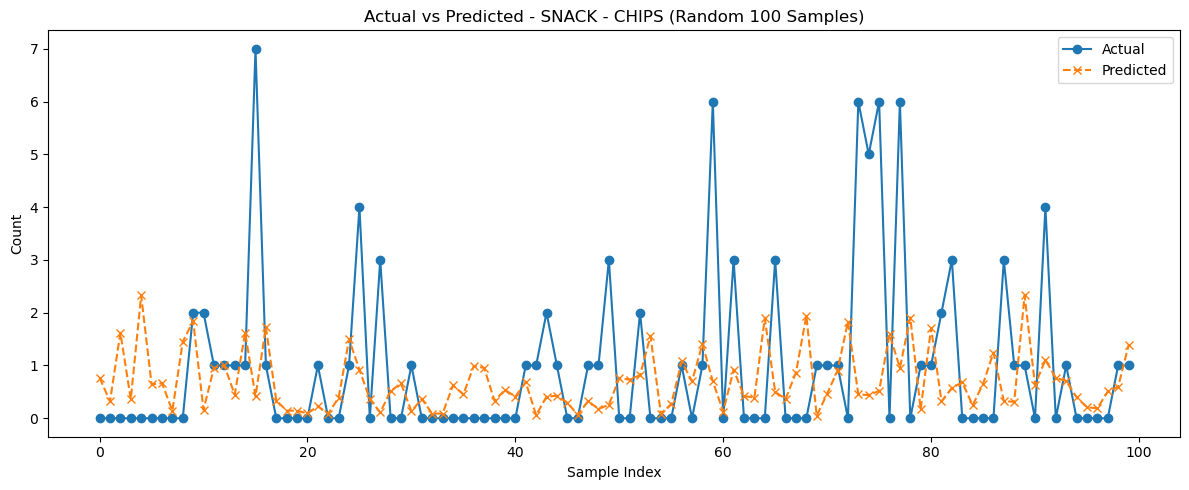

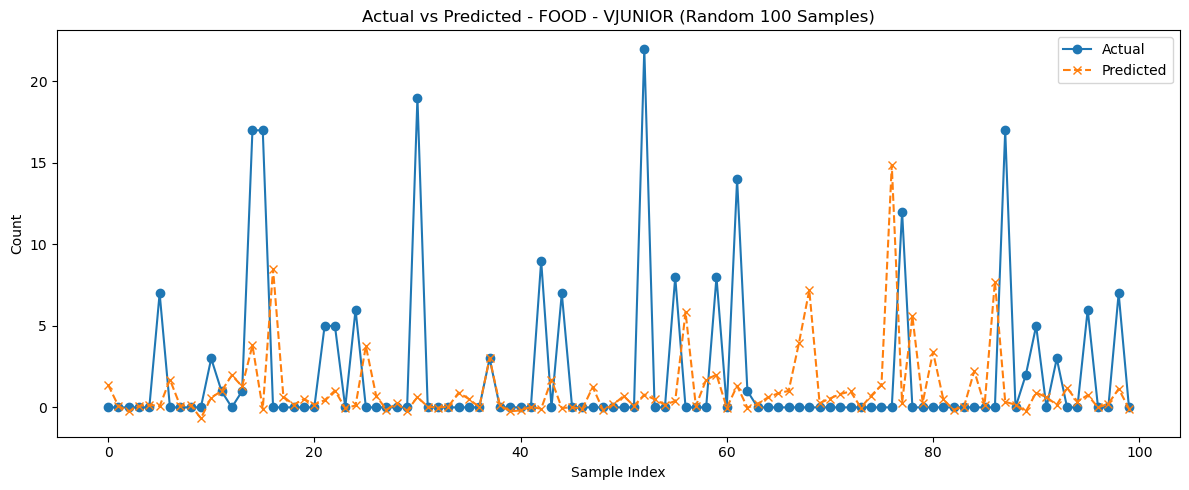

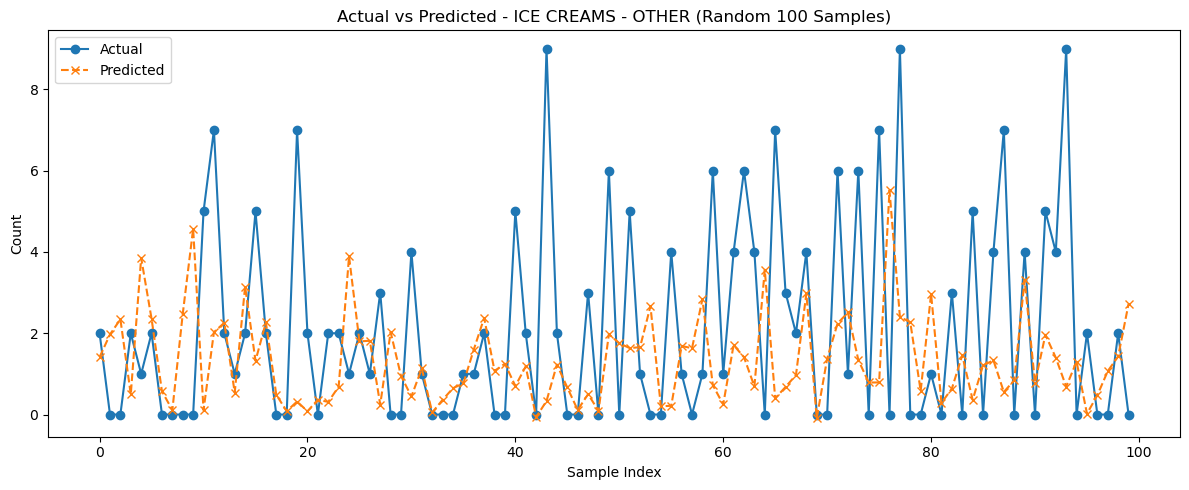

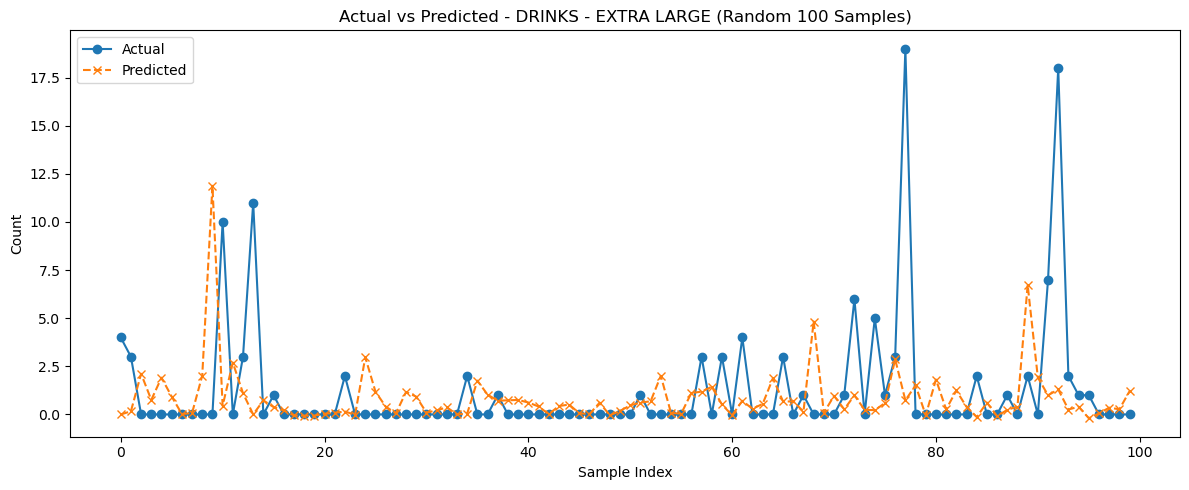

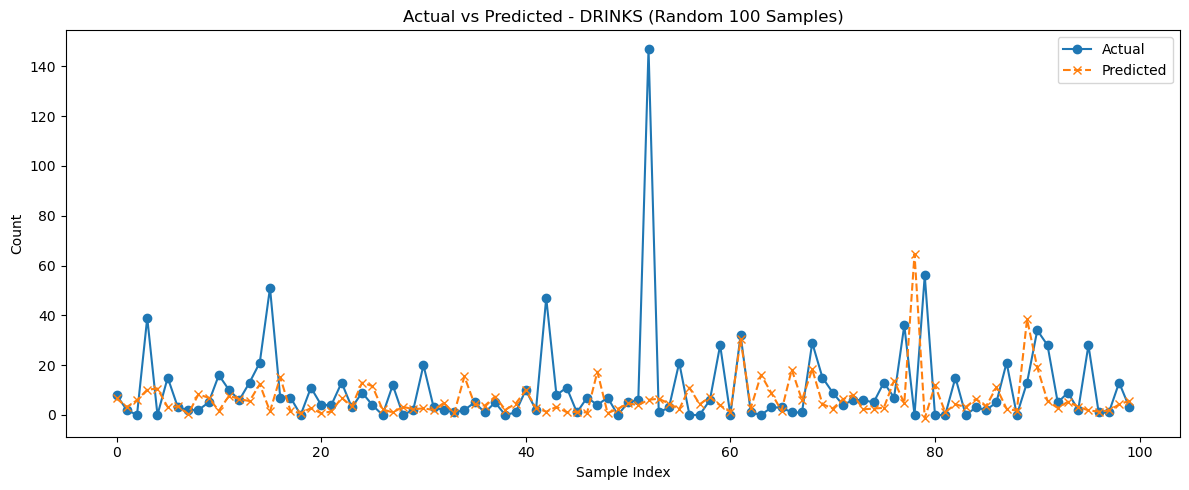

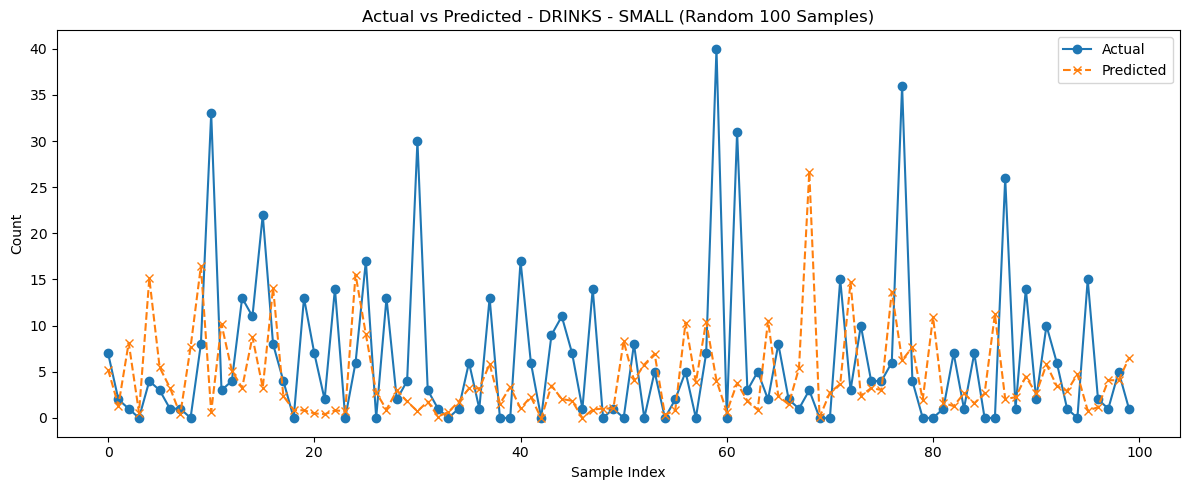

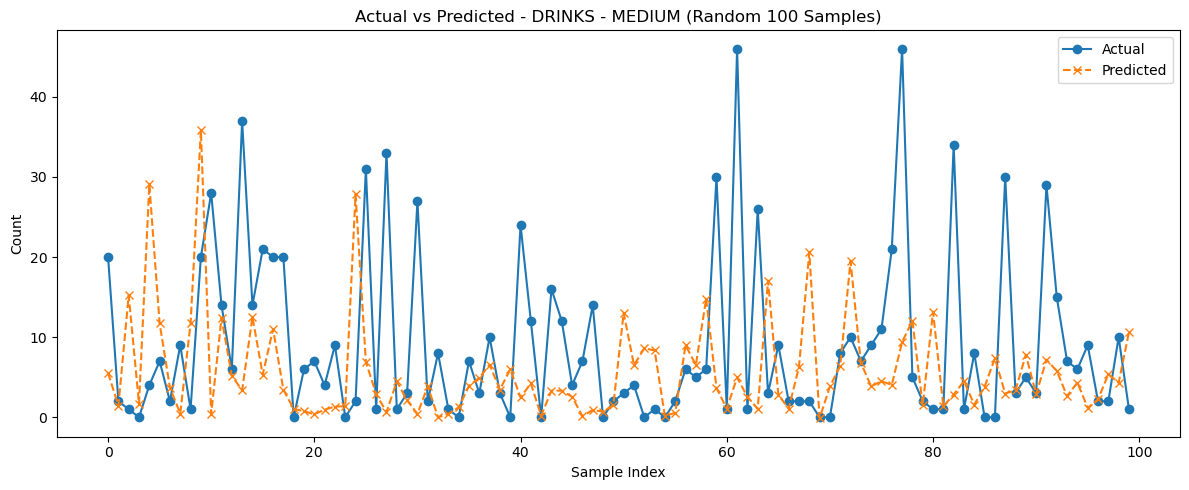

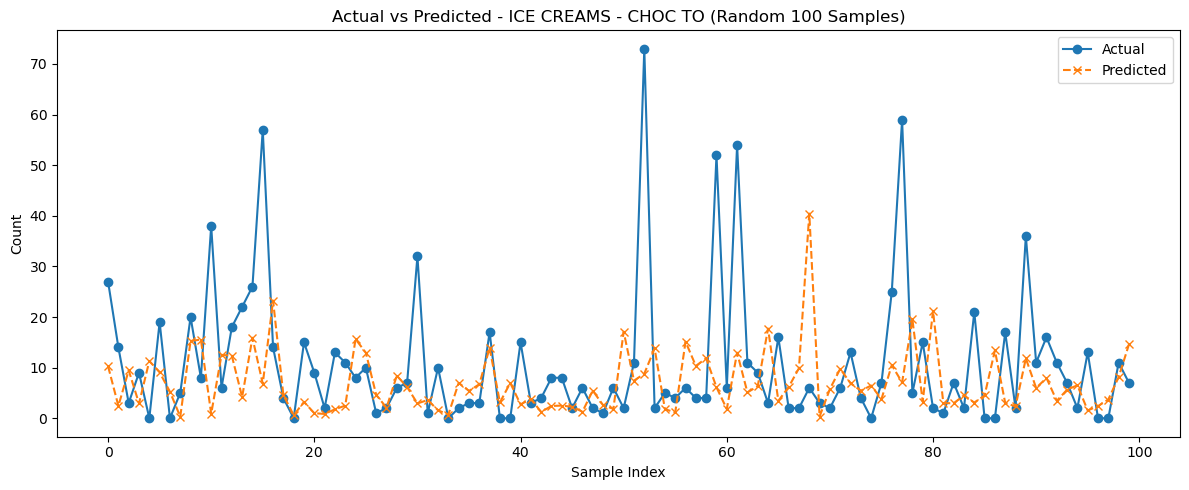

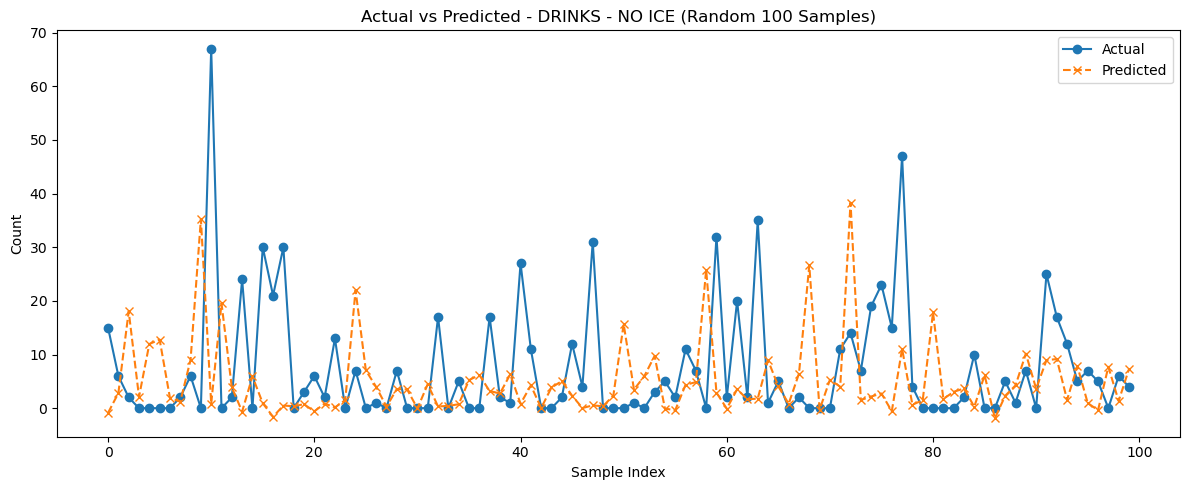

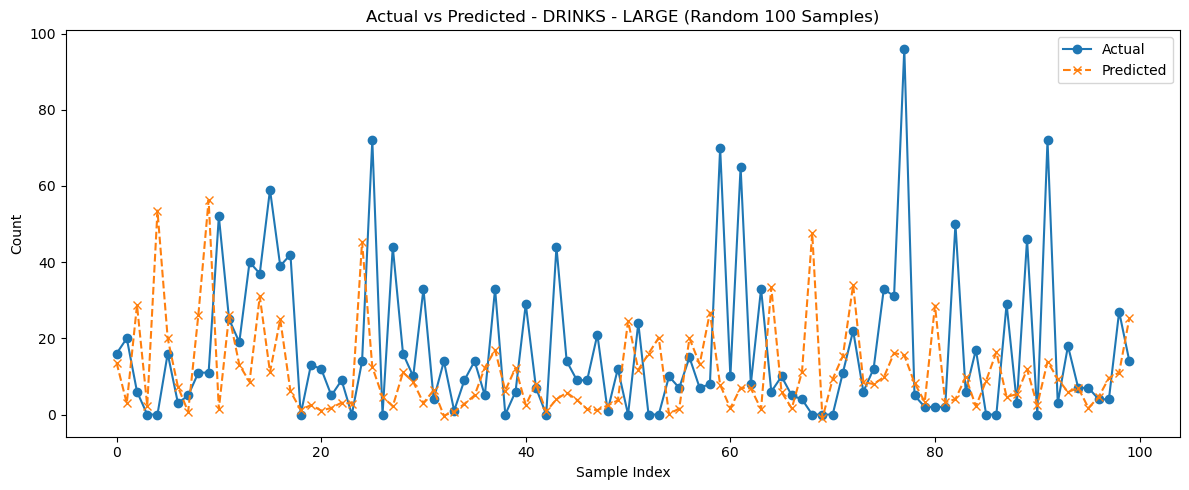

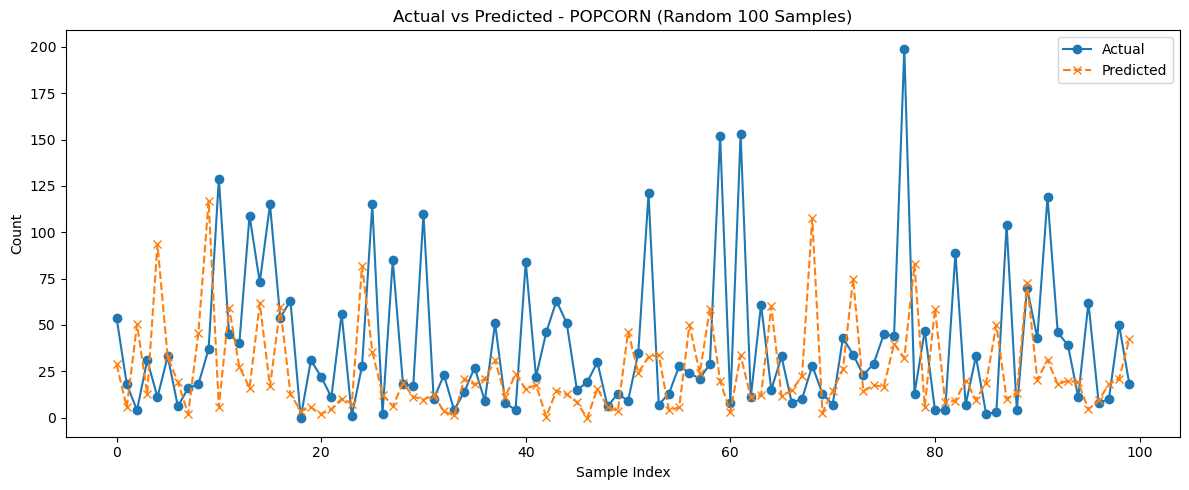

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reconstruct if needed:
# Y_test    = ...  # your test-set DataFrame
# Y_pred_df = ...  # your predictions DataFrame
# target_cols = [...]  # list of target column names

# Number of random samples
n_samples = 100
# Randomly pick indices
random_idx = np.random.choice(Y_test.shape[0], size=n_samples, replace=False)

for col in target_cols:
    actual = Y_test[col].values[random_idx]
    predicted = Y_pred_df[col].values[random_idx]
    
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted - {col} (Random {n_samples} Samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

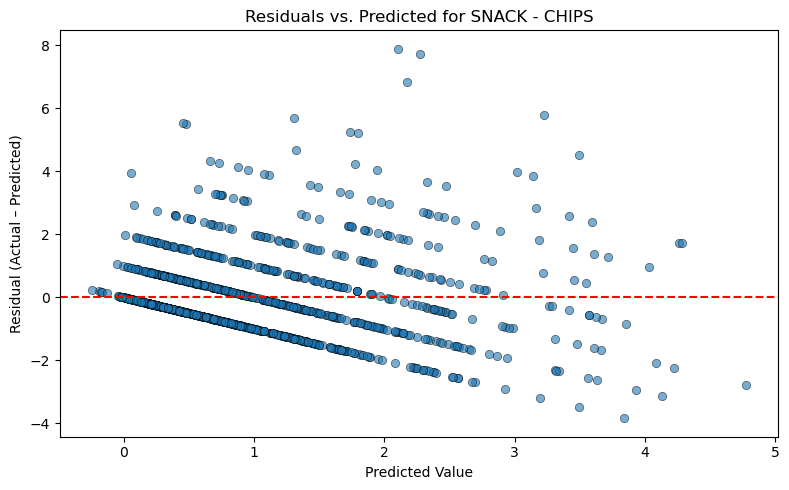

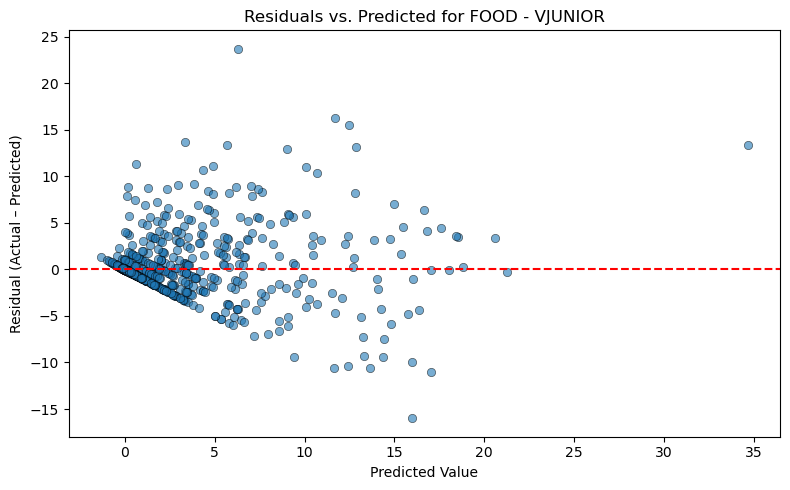

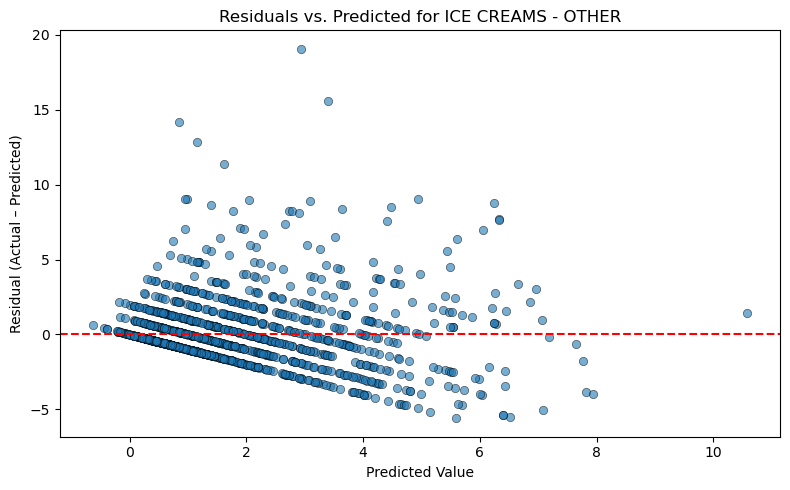

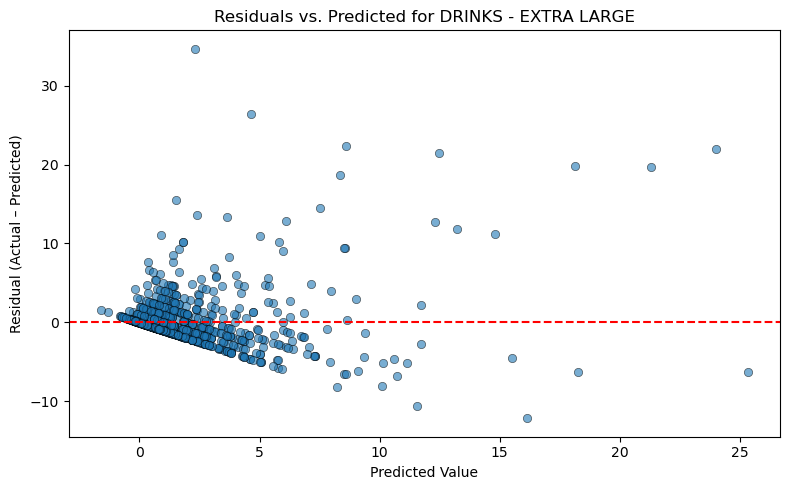

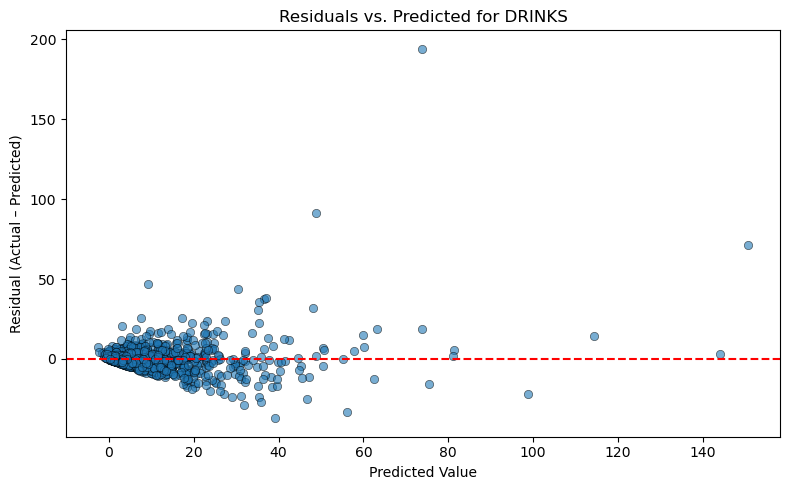

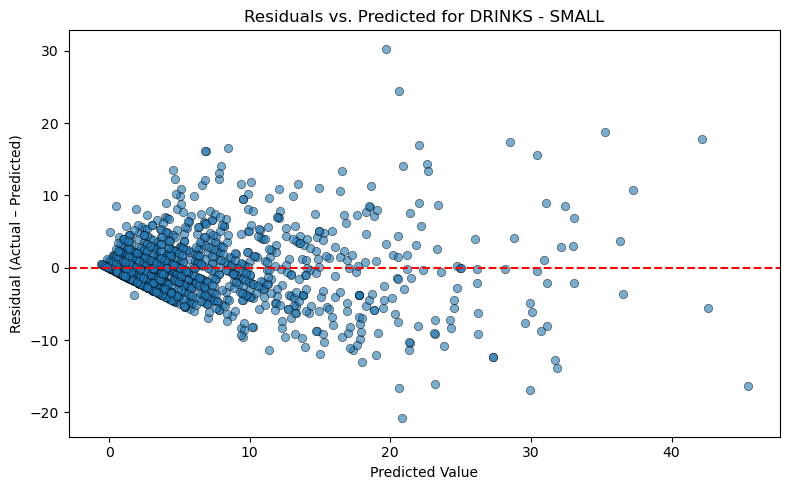

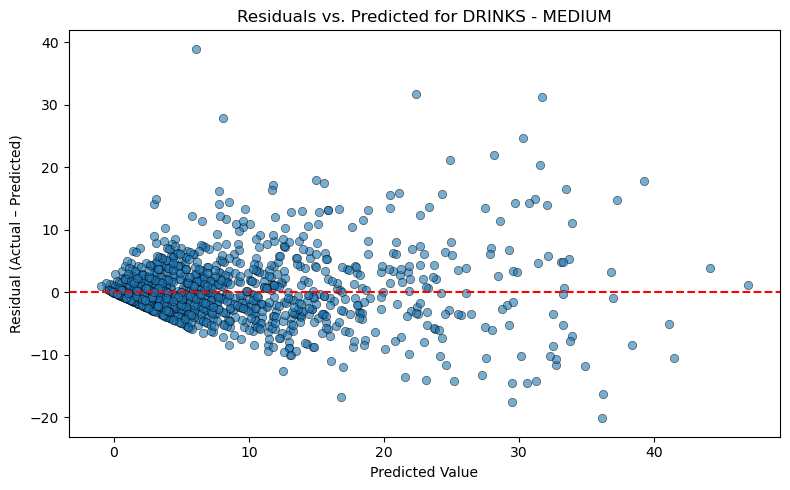

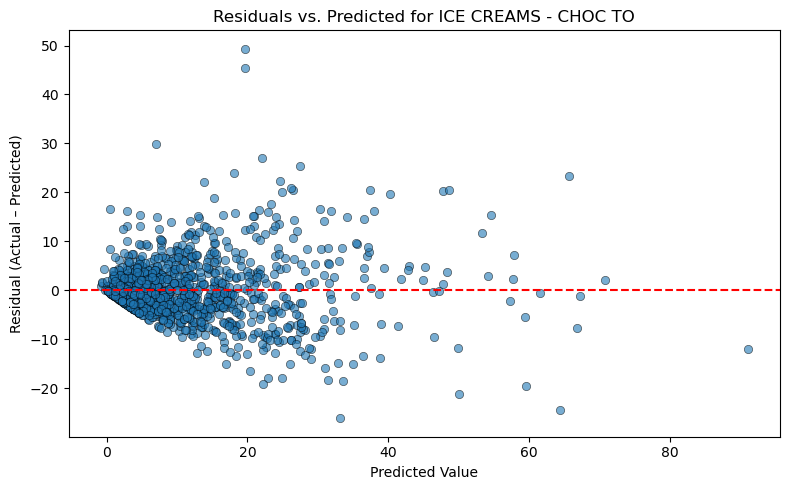

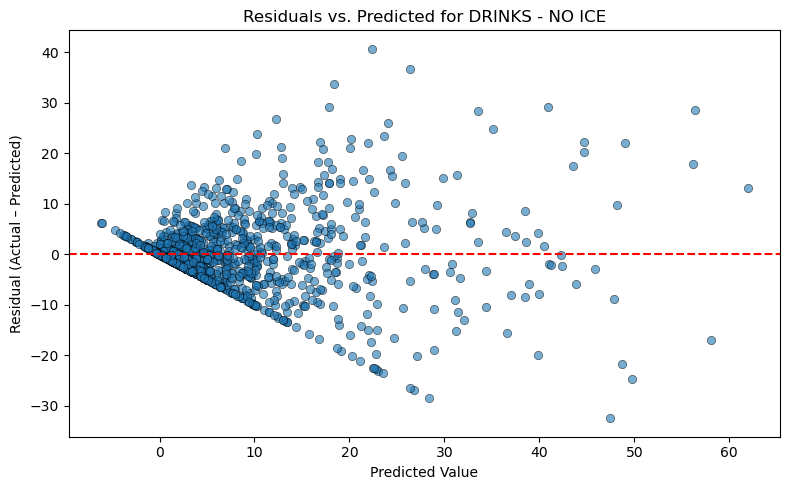

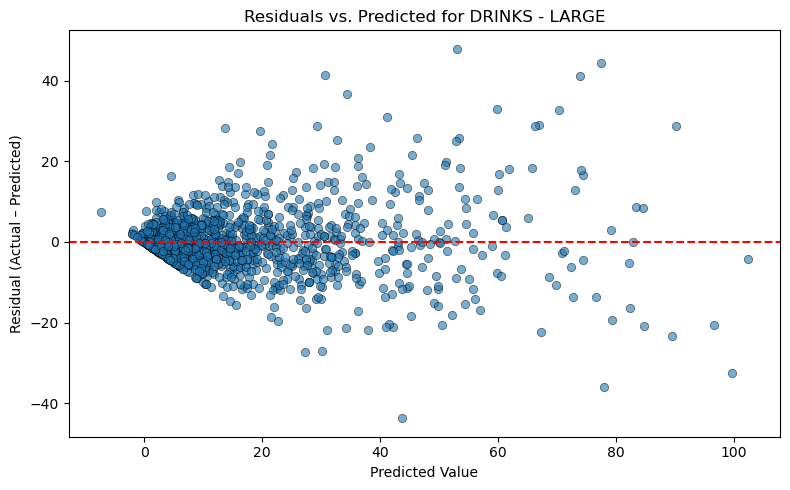

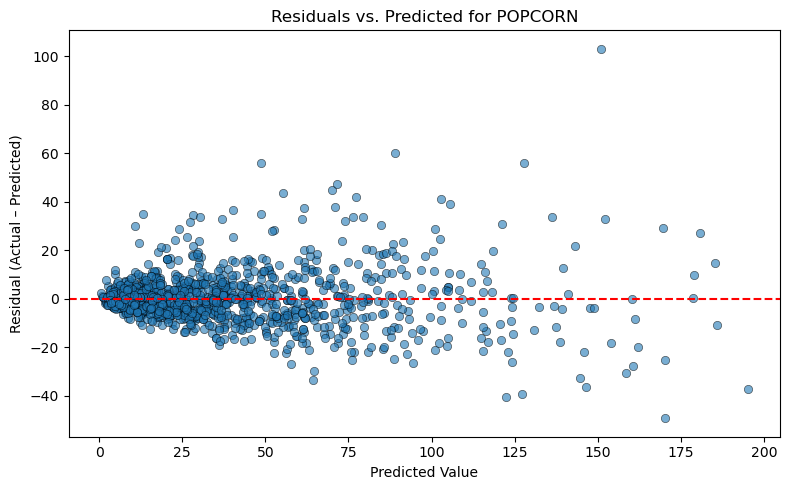

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure predictions are in a DataFrame
Y_pred = best_model.predict(X_test)
Y_pred_df = pd.DataFrame(Y_pred, columns=target_cols, index=Y_test.index)

# Scatter plot residual vs. predicted for each target
for col in target_cols:
    preds = Y_pred_df[col]
    residuals = Y_test[col] - preds

    plt.figure(figsize=(8, 5))
    plt.scatter(preds, residuals, alpha=0.6, edgecolor='k', linewidth=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs. Predicted for {col}")
    plt.xlabel("Predicted Value")
    plt.ylabel("Residual (Actual – Predicted)")
    plt.tight_layout()
    plt.show()
